In [3]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import os
# gin_metrics = ['precision', 'recall', 'density', 'coverage', 'fid', 'kid', 'f1_pr', 'f1_dc', 
#                 'mmd_rbf_quadratic_adaptive', 'mmd_rbf_quadratic', 'mmd_rbf_linear_adaptive',
#                 'mmd_rbf_linear', 'mmd_linear']
# gin_metrics = ['activations', 'precision', 'density', 'recall', 'coverage', 'f1_pr', 'f1_dc', 'mmd_rbf_linear_adaptive', 'mmd_rbf_linear', 'mmd_linear', 'mmd_rbf_quadratic_single', 'mmd_rbf_quadratic_median', 'mmd_rbf_quadratic_adaptive', 'mmd_rbf_quadratic', 'fid', 'kid']
gin_metrics = ['activations', 'precision', 'density', 'recall', 'coverage', 'f1_pr', 'f1_dc', 'fid', 'kid', 'mmd_linear',
               'mmd_rbf_linear_adaptive', 'mmd_rbf_linear', 'mmd_rbf_quadratic', 'mmd_rbf_quadratic_adaptive', 'mmd_rbf_quadratic_single']
#                'mmd_linear', 'mmd_rbf_quadratic_adaptive_median_new', 'mmd_rbf_quadratic_adaptive_mean_new', 'mmd_rbf_quadratic_new', 'mmd_rbf_quadratic_adaptive', 'mmd_rbf_quadratic', 'mmd_rbf_quadratic_single_mean', 'mmd_rbf_quadratic_single_median', 'mmd_rbf_quadratic_single', 'fid', 'kid']
mmd_metrics = ['wl_mmd', 'clustering_mmd', 'degree_mmd', 'orbits_mmd', 'nspdk_mmd']
# mmd_metrics += ['clustering_rbf_range_mmd', 'degree_rbf_range_mmd', 'orbits_rbf_range_mmd']
# mmd_metrics += ['clustering_rbf_mmd', 'degree_rbf_mmd', 'orbits_rbf_mmd']
# mmd_metrics += ['clustering_range_mmd', 'degree_range_mmd', 'orbits_range_mmd']


dont_plot = ['mmd_rbf_linear_adaptive', 'mmd_rbf_linear', 'mmd_rbf_quadratic']
# dont_plot += ['wl_mmd', 'fid', 'kid', 'mmd_linear']
dont_plot += ['mmd_rbf_quadratic_adaptive_median', 'mmd_rbf_quadratic_adaptive_median_new', 'mmd_rbf_quadratic_adaptive_mean_new', 'mmd_rbf_quadratic_new', 'mmd_rbf_quadratic_single_mean', 'mmd_rbf_quadratic_single_median']
dont_plot += ['mmd_rbf_quadratic_single']
dont_plot += ['wl_mmd']

to_plot = [metric for metric in gin_metrics + mmd_metrics if metric not in dont_plot]
print(to_plot)

all_metrics = list(set(gin_metrics + mmd_metrics + dont_plot))

# cmapper = np.linspace(0, 1, len([metric for metric in gin_metrics + mmd_metrics if metric not in dont_plot]))
# cmapper = {key: cmapper[ix] for ix, key in enumerate(gin_metrics + mmd_metrics) if metric not in dont_plot}
cmapper = np.linspace(0, 1, len(to_plot))
cmapper = {key: cmapper[ix] for ix, key in enumerate(to_plot)}
cmap = plt.get_cmap('viridis')
def get_color(metric):
    return cmap(cmapper[metric])

cmapper_qualitative = {}
for c_ix, key in enumerate(to_plot):
    c_ix *= 2
    if c_ix >= 20:
        c_ix = (c_ix % 20) + 1
    cmapper_qualitative[key] = plt.cm.tab20(c_ix)
                      
def get_color_qualitative(metric):
    return cmapper_qualitative[metric]


def should_plot(metric):
    return metric not in dont_plot

def get_label(metric):
    metric_to_label = {'mmd_linear': 'MMD Linear',
                       'mmd_rbf_quadratic_adaptive': 'MMD RBF',
                       'mmd_rbf_quadratic': 'MMD RBF old',
                       'mmd_rbf_quadratic_single': 'MMD RBF (st.)',
                       'mmd_rbf_quadratic_single_median': 'MMD RBF med.',
                       'mmd_rbf_quadratic_single_mean': 'MMD RBF mean',
                       'mmd_rbf_quadratic_adaptive_median_new': 'MMD RBF med. ad.',
                       'mmd_rbf_quadratic_adaptive_mean_new': 'MMD RBF mean ad.',
                       'mmd_rbf_quadratic_new': 'MMD RBF new',
                       'fid': 'FD',
                       'kid': 'KD',
                       'degree_mmd': 'Degree MMD',
                       'clustering_mmd': 'Clustering MMD',
                       'wl_mmd': 'WL MMD',
                       'nspdk_mmd': 'NSPDK MMD',
                       'orbits_mmd': 'Orbits MMD',
                       'f1_pr': 'F1 PR',
#                        'f1_pr': 'F1 PR/Precision/Recall',
                       'f1_dc': 'F1 DC'}
#                        'f1_dc': 'F1 DC/Density/Coverage'}
    
    if metric in metric_to_label:
        return metric_to_label[metric]
    elif '_' not in metric: # PRDC
        return metric.title()
    elif 'mmd' not in metric: # F1 scores
        return ' '.join(metric.split('_')).upper()

plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=24) # 26     # fontsize of the axes title
plt.rc('axes', labelsize=24)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=22)    # fontsize of the tick labels
plt.rc('ytick', labelsize=22)    # fontsize of the tick labels
plt.rc('legend', fontsize=24)    # legend fontsize
plt.rc('figure', titlesize=12)  # fontsize of the figure title\

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
['activations', 'precision', 'density', 'recall', 'coverage', 'f1_pr', 'f1_dc', 'fid', 'kid', 'mmd_linear', 'mmd_rbf_quadratic_adaptive', 'clustering_mmd', 'degree_mmd', 'orbits_mmd', 'nspdk_mmd']


# Preprocessing rank corr + sample-size exps

In [64]:
import os
import shutil
from utils.experiment_logging import get_results, get_config
import numpy as np

def is_experiment_complete(results, config):
    if 'computation' in config['permutation_type'] or 'GIN_train':
        return True
    
    ratio_key = 'ratio'
    ratio = results[-1][ratio_key]
    return ratio == 1

def delete_incomplete():
    good, bad = 0, 0
    for root, subdir, files in os.walk('experiment_results'):
        if 'logfile.log' not in files or 'computation' in root or 'GIN_train' in root:
            continue
        if 'results.h5' not in files:
            bad += 1
            shutil.rmtree(root)
            continue

        config = get_config(run_dir=root)
        results = get_results(run_dir=root)
        if not is_experiment_complete(results, config):
            shutil.rmtree(root)
            print('rm', root)
            bad += 1
            continue    
        good += 1
            
    print(f'Num complete: {good}, incomplete: {bad}')

In [65]:
delete_incomplete()

Num complete: 41925, incomplete: 126


In [66]:
def delete_duplicate_runs():
    configs = []
    all_exps = []
    dupes = []
    for root, subdir, files in os.walk('experiment_results'):
        if 'results.h5' not in files or 'computation' in root or 'GIN_train' in root:
            continue
            
        all_exps.append(root)
        config = get_config(run_dir=root)
        del config['git_commit']
        del config['no_cuda']
        del config['res_dir']
        del config['step_size']
        del config['model_path']
        del config['overfitting_version']
        
        if config in configs:
            print('dupe', root)
            dupes.append(root)
#             shutil.rmtree(root)
            continue
    
        configs.append(config)
    print(dupes)
    print(f'deleted {len(dupes)} duplicates')

In [67]:
delete_duplicate_runs()

dupe experiment_results/mode-collapse/proteins/mmd-structure/gaussian_emd/degree/20211113-0905-6gskEuVFfl
dupe experiment_results/mode-collapse/zinc/mmd-structure/nspdk/20211113-1213-AtSWt1h4Yl
dupe experiment_results/mode-collapse/zinc/gcn/sum/20211113-1812-hiN5gC6FjJ
dupe experiment_results/mode-collapse/zinc/gcn/sum/20211113-1431-ZTftcnJPe2
dupe experiment_results/mode-collapse/zinc/gcn/sum/20211114-1451-mvSsLiRTiq
dupe experiment_results/mode-collapse/zinc/gcn/sum/20211113-0943-JERoa1vD0G
dupe experiment_results/mode-collapse/zinc/gcn/sum/20211113-0602-GYzkzFC1x4
dupe experiment_results/mode-collapse/zinc/gcn/sum/20211113-0912-18cDRMEYDC
dupe experiment_results/mode-collapse/zinc/gcn/sum/20211113-0253-JvH1wDmxXs
dupe experiment_results/mode-collapse/zinc/gcn/sum/20211112-2207-YqLqX6Rk7D
dupe experiment_results/mode-collapse/zinc/gcn/sum/20211112-1309-T3PPEfnMxU
dupe experiment_results/mode-collapse/zinc/gcn/sum/20211113-2230-6u2MJDAGoB
dupe experiment_results/mode-collapse/zinc/gcn

In [46]:
import pickle
from utils.experiment_logging import get_results, get_config


def update_sample_size_runs():
    for root, subdir, files in os.walk('experiment_results'):
        if 'results.h5' not in files or 'sample-size' not in root:
            continue
        exp_results = get_results(run_dir=root)
        config = get_config(run_dir=root)
                
        if config['feature_extractor'] != 'mmd-structure':
            keys = gin_metrics[1: ]
        elif config['feature_extractor'] == 'mmd-structure':
#             if config['statistic'] != 'WL':
            metric = config['statistic']
            if 'WL' != metric and 'nspdk' != metric:
                if config['kernel'] == 'gaussian_rbf':
                    metric += '_rbf'
                if config['sigma'] == 'range':
                    metric += '_range'
                    
            keys = [metric.lower() + '_mmd']

        if 'sample_size_' + keys[0] in exp_results[0].keys():
            continue
        
        if config['sigma'] == 'range':
            print('range')
        
#         print(root)
#         print(exp_results[0].keys(), root)
        tmp_results = {}
        sample_sizes = [[dct['sample_size'] for dct in exp_results]]
        for key in keys:
            try:
                tmp = np.array([[dct[key] for dct in exp_results]])
            except KeyError:
                continue
            tmp[tmp >= 0] = 0

            for run, s_size in zip(tmp, sample_sizes):
                converge_point = np.argmax([np.sum(run[i:]) for i in range(len(run))])
                sample_size = s_size[converge_point]
#                 sample_size = s_size[converge_point] / np.max(s_size)
            for dct in exp_results:
                dct['sample_size_' + key] = sample_size
        os.remove(os.path.join(root, 'results.h5'))
        for dct in exp_results:
            pickle.dump(dct, open(os.path.join(root, 'results.h5'), 'ab+'))

In [47]:
update_sample_size_runs()

In [115]:
from utils.experiment_logging import get_results, get_config
import json

def update_mmd_sigmas():
    for root, subdir, files in os.walk('experiment_results'):
        if 'results.h5' not in files or 'gaussian_emd' not in root:
            continue
        
        config = get_config(run_dir=root)
        if 'sigma' not in config:
            print('n')
            config['sigma'] = 'single'
            
#             json.dump(config, open(os.path.join(root, 'config_save.json'), 'w'), indent=4, sort_keys=True)
#         os.remove(os.path.join(root, 'config_temp.json'))
        
update_mmd_sigmas()

In [48]:
import pandas as pd
import os
from utils.experiment_logging import get_results, get_config

def del_config_keys(config):
    del config['git_commit']
    del config['no_cuda']
    del config['res_dir']
    del config['seed']
    del config['step_size']
    del config['model_path']
    del config['overfitting_version']
    del config['output_dim']
    try:
        del config['generative_model']
    except:
        pass
    try:
        del config['use_degree_features']
    except:
        pass
    try:
        del config['edge_feat_dim']
    except:
        pass
    del config['input_dim']

    if config['feature_extractor'] == 'mmd-structure':
        del config['use_pretrained']
        del config['use_constant_permutations']
        del config['use_constant_model']
        del config['max_workers']
        del config['is_parallel']
#         del config['kernel']
        
def get_all_keys():
    keys = None
    for root, subdir, files in os.walk('experiment_results'):
        if 'GIN_train' in root or 'computation' in root or 'results.h5' not in files:
            continue
        results = get_results(run_dir=root)
        config = get_config(run_dir=root)

        del_config_keys(config)

        if keys is None:
            keys = list(config.keys())
        for key in config.keys():
            if key not in keys:
                keys += [key]
            
    return keys


df = pd.DataFrame()
extra_keys = ['metric', 'result']
extra_keys = ['metric', 'result', 'line', 'ratio']

# keys = get_all_keys()
# keys += extra_keys
all_results = {key: [] for key in keys}
for root, subdir, files in os.walk('experiment_results'):
#     if 'GIN_train' in root or 'computation' in root or 'results.h5' not in files or 'mixing-gen' not in root:
    if 'GIN_train' in root or 'computation' in root or 'results.h5' not in files:
        continue
        
    results_full_run = get_results(run_dir=root)
    try:
        results = results_full_run[0]
    except:
        print(root, results_full_run)
        continue
    config = get_config(run_dir=root)

    del_config_keys(config)
    if config['feature_extractor'] != 'mmd-structure' or config['statistic'] != 'nspdk':
#     if config['feature_extractor'] != 'gin' and config['feature_extractor'] != 'mmd-structure':
        continue
        
    for metric in all_metrics:
#         print(metric)
        metric_key = 'rank_corr_' + metric if 'sample-size' not in config['permutation_type'] else 'sample_size_' + metric
        if metric_key in results:
            all_results['result'].append(results[metric_key])
            all_results['metric'].append(metric)
            
            if 'ratio' in extra_keys:
                all_results['line'].append([res[metric] for res in results_full_run])
                all_results['ratio'].append([res['ratio'] for res in results_full_run])
            
            for key in all_results.keys():
                if key not in extra_keys:
                    if key not in config:
                        all_results[key].append(None)
                    else:
                        all_results[key].append(config[key])
#     break
df = pd.DataFrame(all_results)

In [49]:
def group_config(df):
    df['config'] = df.apply(lambda row: get_config(row), axis=1)
    
def group_config_metric(df):
    df['config_metric'] = df.apply(lambda row: get_config_metric(row), axis=1)
    
def get_config(row):
    if row['feature_extractor'] == 'gin':
        return  'N: {}, P: {}, G: {}'.format(int(row['hidden_dim']), int(row['num_layers']), int(row['graph_embed_size']))
    else:
        return ''

def get_config_metric(row):
    if row['feature_extractor'] == 'gin':
        return  'N: {}, P: {}, G: {}, {}'.format(int(row['hidden_dim']), int(row['num_layers']), int(row['graph_embed_size']), get_label(row['metric']))
    else:
        return ''
    
group_config(df)
group_config_metric(df)

import pickle
pickle.dump(df, open('results_rebuttal_nspdk.h5', 'wb'))

# Line plot

In [8]:
datasets = ['proteins', 'grid', 'community', 'ego', 'lobster']
experiments = ['rewiring-edges', 'mixing-random', 'mode-dropping', 'mode-collapse']
# experiments = ['rewiring-edges', 'mixing-random', 'mode-dropping', 'mode-collapse', ['rewiring-edges', 'mixing-random'], ['mode-dropping', 'mode-collapse']]
# experiments = ['mixing-gen']
metrics_to_avoid = ['fid', 'kid', 'mmd_linear']

linestyles = {'mmd_rbf_quadratic_adaptive': {'linestyle': '-', 'marker': 'X'},
              'f1_pr': {'linestyle': '-', 'marker': 'o'},
              'f1_dc': {'linestyle': '-', 'marker': 'v'},
              'coverage': {'linestyle': '-.', 'marker': 'X'},
              'recall': {'linestyle': '-.', 'marker': 'o'},
              'density': {'linestyle': ':', 'marker': 'X'},
              'precision': {'linestyle': ':', 'marker': 'o'},
              'orbits_mmd': {'linestyle': '--', 'marker': 'X'},
              'clustering_mmd': {'linestyle': '--', 'marker': 'o'},
              'degree_mmd': {'linestyle': '--', 'marker': 'v'},
              'nspdk_mmd': {'linestyle': '--', 'marker': '^'},
              'wl_mmd': {'linestyle': '--', 'marker': '^'},
#               'mmd_rbf_quadratic_single': {'linestyle': '-', 'marker': '>'}
             }
plt.rc('legend', fontsize=16)    # legend fontsize

def plot_line_plot(axs, exps, datasets, pretrained=False, init='orthogonal', metrics=to_plot, title=None):
# for exp in experiments:
#     if type (exps) == list:
    filtered = filter_df(exps, datasets, metrics=metrics, init=init, pretrained=pretrained)#, configs=['N: 35, P: 3, G: 70'])
#     else:
#         filtered = filter_df([exps], datasets, metrics=to_plot)#, configs=['N: 35, P: 3, G: 70'])
    metrics = list(filtered['metric'].unique())
    results = {key: [] for key in metrics}
    i = 0
    for ix, row in filtered.iterrows():
    #     print(ix, row)
        metric = row['metric']
        line_results = row['line']
        ratio_results = row['ratio']
        interpolated = np.interp(np.arange(0, 1, 0.01), ratio_results, line_results)
        results[metric].append(interpolated)
#     fig, axs = plt.subplots(figsize=(12.5, 10)) # To plot just comp-eff quantity


    for key, result in results.items():
        if key in metrics_to_avoid:
            continue
        results[key] = np.concatenate([res.reshape(1, -1) for res in result], axis=0)

        x_axis = np.arange(0, 1, 0.01)
        mean = np.mean(results[key], axis=0)
        std = np.std(results[key], axis=0)
        try:
            kwargs = linestyles[key]
        except:
            print(key, 'not in ls')
            continue
        axs.plot(x_axis, mean, color=get_color_qualitative(key), label=get_label(key), markevery=5, **kwargs) #markersize=8, lw=3, **kwargs)
#         if key in mmd_metrics:
#             axs.fill_between(x_axis, mean + std, mean - std, color=get_color_qualitative(key), alpha=0.3)
        axs.set_ylabel(r'$\hat \rho(\mathbb{S}_g, \mathbb{S}_r)$')
        axs.set_xlabel(r'Degree of perturbation')
#         axs.set_xlabel(r'Ratio ($t$)')
#         if title is None:
#             axs.set_title(get_experiment_title(exps[0]))
#         else:
#             axs.set_title(title)
        axs.set_ylim(-0.01, 1.1)

#     leg = axs.legend(loc='lower right', ncol=3)
    
#     for text in leg.get_texts():
#         metric = text.get_text()
#         if 'MMD' in metric and 'RBF' not in metric:
#             color = 'b'
#         else:
#             color = 'r'
#         plt.setp(text, color=color)

    # Get the bounding box of the original legend
#     bb = leg.get_bbox_to_anchor().inverse_transformed(axs.transAxes)

#     # Change to location of the legend. 
#     # xOffset = 0.2 # Play with this to tweak position of legend
#     yOffset = 0.6 # Play with this to tweak position of legend
#     bb.y0 -= yOffset
#     bb.y1 -= yOffset
#     xOffset = -0
#     bb.x0 -= xOffset
#     bb.x1 -= xOffset
#     leg.set_bbox_to_anchor(bb, transform = axs.transAxes)
    
#     fig.savefig(exp + '.jpg', bbox_inches='tight')


rewiring-edges


/home/rylee/python/pna/env/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.


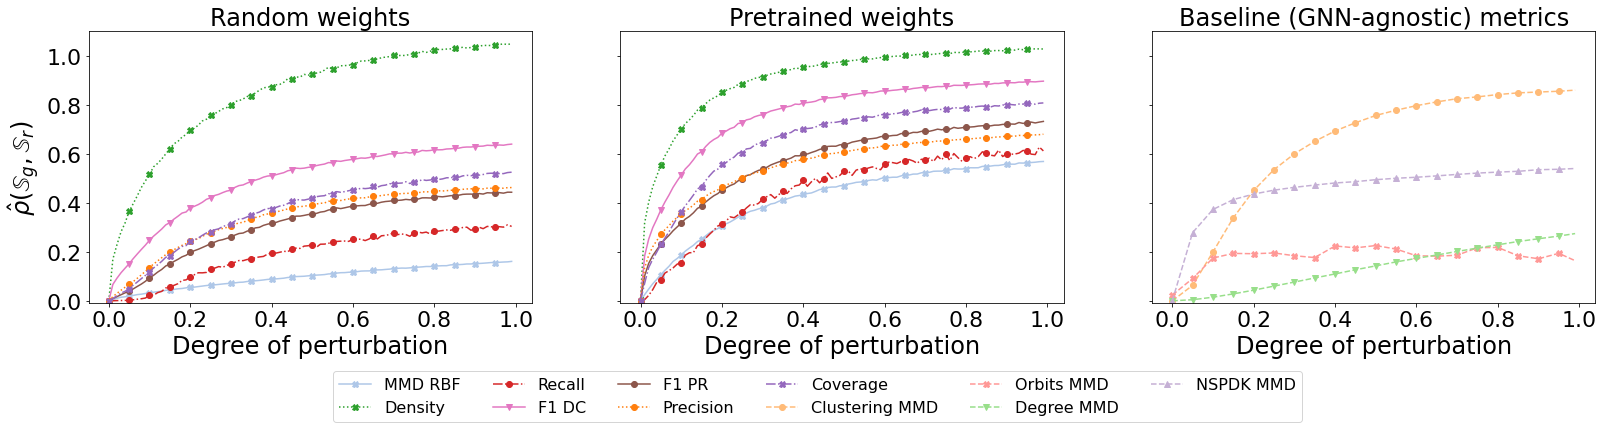

mixing-random


/home/rylee/python/pna/env/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.


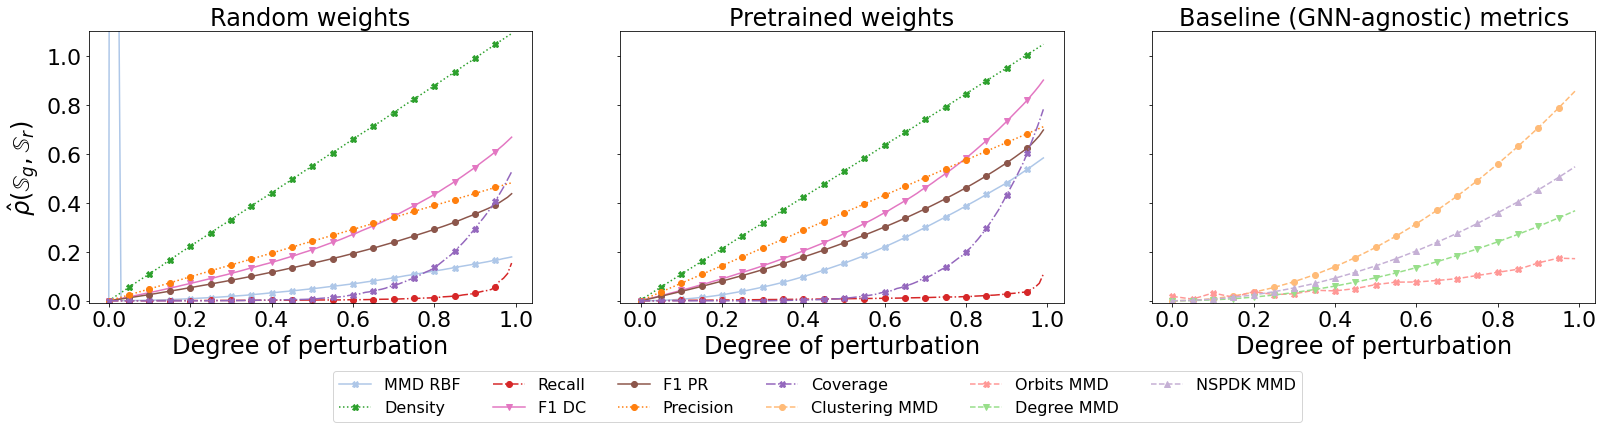

mode-dropping


/home/rylee/python/pna/env/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.


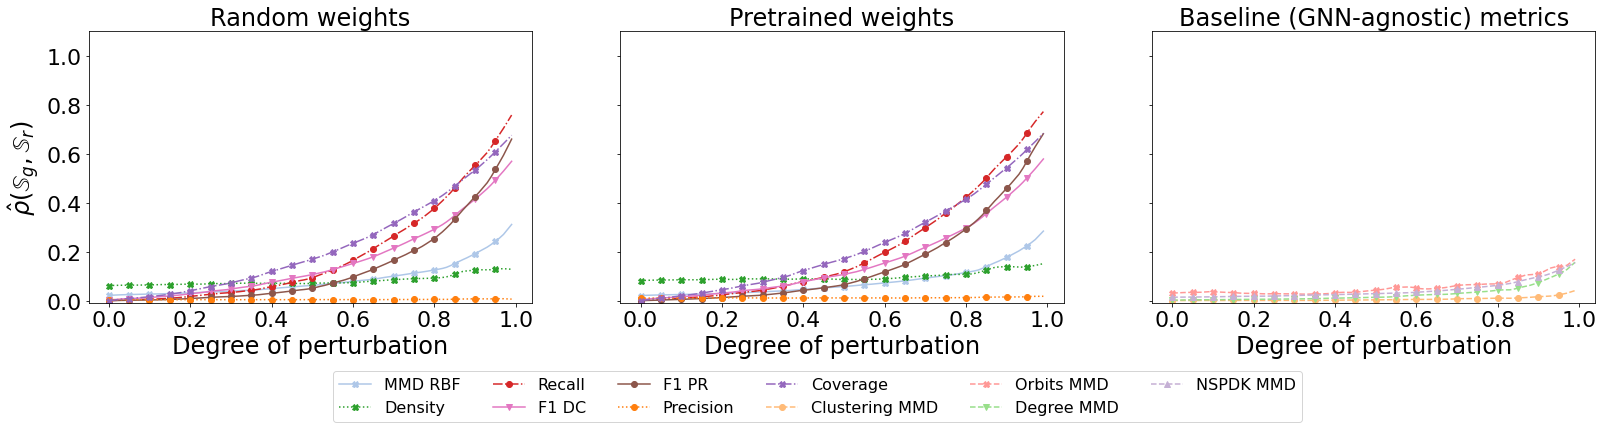

mode-collapse


/home/rylee/python/pna/env/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.


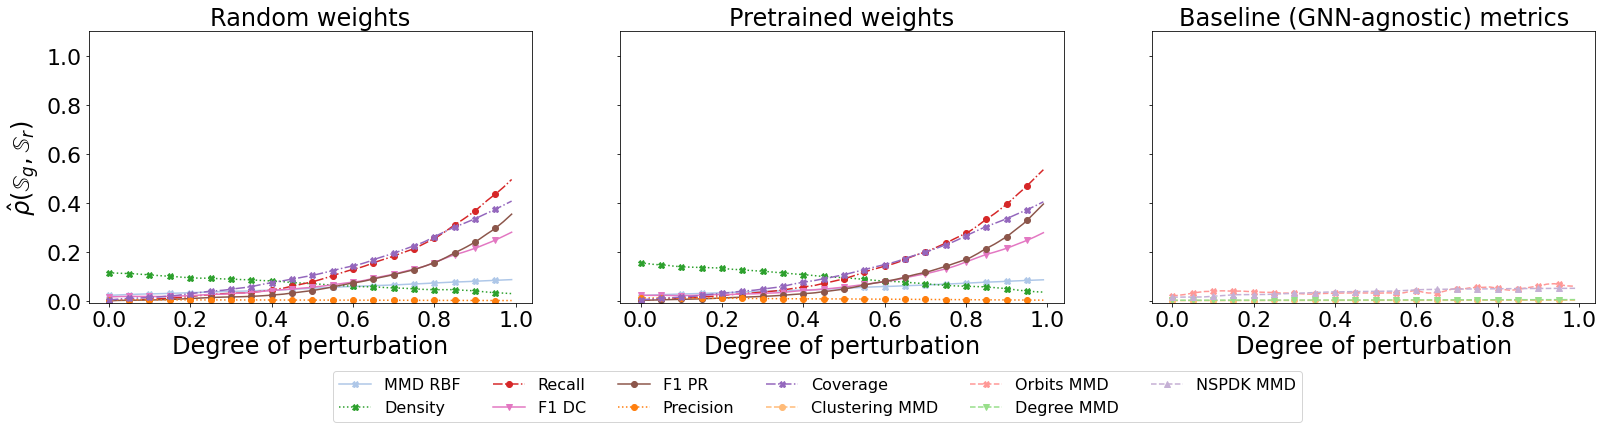

In [11]:
# experiments = ['mixing-gen']
# experiments = ['rewiring-edges', 'mixing-random', 'mode-dropping', 'mode-collapse']#, ['rewiring-edges', 'mixing-random'], ['mode-dropping', 'mode-collapse']]
datasets = ['proteins', 'grid', 'community', 'ego', 'lobster']

for exp in experiments:
    print(exp)
    fig, axes = plt.subplots(1, 3, figsize=(27, 5))
    plot_line_plot(axes[0], [exp], datasets, metrics=[metric for metric in gin_metrics if metric in to_plot], title='Random weights')
    plot_line_plot(axes[1], [exp], datasets, pretrained=True, init='default', metrics=[metric for metric in gin_metrics if metric in to_plot], title='Pretrained weights')
    plot_line_plot(axes[2], [exp], datasets, metrics=mmd_metrics, title='Baseline metrics')
    h1, l1 = axes[1].get_legend_handles_labels()
    h2, l2 = axes[2].get_legend_handles_labels()
    axes[1].set_ylabel('')
    axes[1].set_yticklabels([])
    axes[2].set_ylabel('')
    axes[2].set_yticklabels([])
    axes[0].set_title('Random weights')
    axes[1].set_title('Pretrained weights')
    axes[2].set_title('Baseline (GNN-agnostic) metrics')
    leg = fig.legend(h1+h2, l1+l2, loc='lower center', ncol=6)
    #     # Get the bounding box of the original legend
    
    bb = leg.get_bbox_to_anchor().inverse_transformed(axes[0].transAxes)

    # Change to location of the legend. 
    # xOffset = 0.2 # Play with this to tweak position of legend
    yOffset = 0.3 # Play with this to tweak position of legend
    bb.y0 -= yOffset
    bb.y1 -= yOffset
    xOffset = 0
    bb.x0 -= xOffset
    bb.x1 -= xOffset
    leg.set_bbox_to_anchor(bb, transform = axes[0].transAxes)
    plt.show()
    
#     fig.savefig(f'paper/paper-figures2/{exp}/line_plot.jpg', bbox_inches='tight')
    fig.savefig(f'paper/paper-figures2/{exp}/line_plot.pdf', bbox_inches='tight')
#     break

['mmd_rbf_quadratic_adaptive' 'density' 'recall' 'fid' 'f1_dc' 'kid'
 'f1_pr' 'precision' 'coverage' 'mmd_linear' 'clustering_mmd' 'orbits_mmd'
 'degree_mmd' 'nspdk_mmd'] metricmetric
['precision', 'density', 'recall', 'coverage', 'f1_pr', 'f1_dc', 'fid', 'kid', 'mmd_linear', 'mmd_rbf_quadratic_adaptive', 'clustering_mmd', 'degree_mmd', 'orbits_mmd', 'nspdk_mmd'] metric
['mmd_rbf_quadratic_adaptive' 'density' 'recall' 'fid' 'f1_dc' 'kid'
 'f1_pr' 'precision' 'coverage' 'mmd_linear' 'clustering_mmd' 'orbits_mmd'
 'degree_mmd' 'nspdk_mmd'] metricmetric
['precision', 'density', 'recall', 'coverage', 'f1_pr', 'f1_dc', 'fid', 'kid', 'mmd_linear', 'mmd_rbf_quadratic_adaptive', 'clustering_mmd', 'degree_mmd', 'orbits_mmd', 'nspdk_mmd'] metric


/home/rylee/python/pna/env/lib/python3.7/site-packages/ipykernel_launcher.py:78: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.


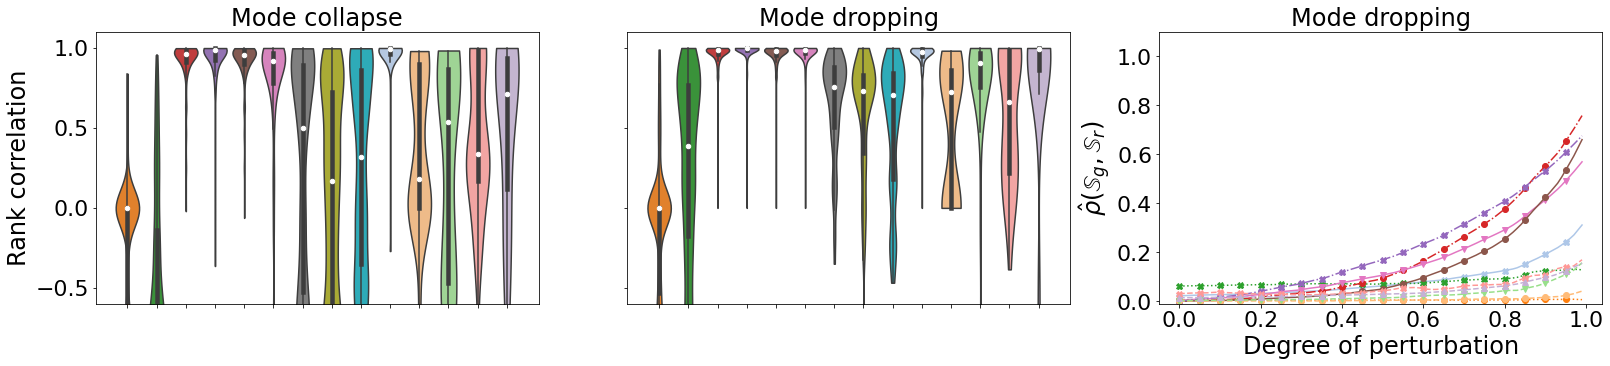

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(27, 5))
# fig, axes = plt.subplots(1, 2, figsize=(18, 5))

exp = 'diversity'
if exp == 'fidelity':
    exps = ['mixing-random', 'rewiring-edges']
#     exps = ['mixing-gen']
else:
    exps = ['mode-collapse', 'mode-dropping']

# metrics = kwargs.get('metrics', plot_metrics)
metrics = to_plot[1:]
plot_results(axes[0], [exps[0]], datasets, metrics=metrics)
axes[0].set_title(get_experiment_title(exps[0]))

plot_results(axes[1], [exps[1]], datasets, metrics=metrics)
axes[1].set_title(get_experiment_title(exps[1]))
axes[1].set_ylabel('')
axes[1].set_yticklabels([])

plot_line_plot(axes[2], [exps[1]], datasets)
axes[2].set_title(get_experiment_title(exps[1]))

if exp == 'diversity':
    axes[0].set_xticklabels([])
    axes[1].set_xticklabels([])
    axes[2].legend().set_visible(False)

# if exp == 'fidelity':
fig.savefig(f'paper/paper-figures2/{exp}.pdf', bbox_inches='tight')
# fig.savefig(f'paper/paper-figures2/mixing-gen.pdf', bbox_inches='tight')


# Plotting rank corr + sample-size exps

In [4]:
import pickle
import pandas as pd
# df = pickle.load(open('results_rebuttal_line.h5', 'rb'))
df = pickle.load(open('results_rebuttal_no_line.h5', 'rb'))
# df = pickle.load(open('rebuttal_mixing_gen.h5', 'rb'))

In [9]:
df['config'].unique().tolist().index('N: 15, P: 7, G: 90')

0

In [14]:
import pickle
import pandas as pd


def filter_df(experiments, datasets, **kwargs):
    constant_permutations = kwargs.get('constant_permutations', False)
    constant_model = kwargs.get('constant_model', False)
    pretrained = kwargs.get('pretrained', False)
    init = kwargs.get('init', 'orthogonal')
    
    metrics = kwargs.get('metrics', gin_metrics)
    configs = kwargs.get('configs', 'all')
    feat_extractor = kwargs.get('gnn', 'gin')
    sigma = kwargs.get('sigma', 'single')
    kernel = kwargs.get('kernel', 'gaussian_emd')
            
    filtered = df.loc[df['permutation_type'].isin(experiments)]
    filtered = filtered.loc[filtered['dataset'].isin(datasets)]
    filtered_metrics = filtered.loc[filtered['metric'].isin(metrics)]
    filtered_metrics = filtered_metrics.loc[~filtered['metric'].isin(dont_plot)]
    
    if 'clustering_mmd' not in metrics and 'nspdk_mmd' not in metrics: # GIN only
        filtered = filtered_metrics.loc[filtered_metrics['use_constant_permutations'] == constant_permutations]
        filtered = filtered.loc[filtered['use_constant_model'] == constant_model]
        filtered = filtered.loc[filtered['use_pretrained'] == pretrained]
        filtered = filtered.loc[filtered['init'] == init]
        filtered = filtered.loc[filtered['feature_extractor'] == feat_extractor]
        if configs != 'all':
            filtered = filtered.loc[filtered['config'].isin(configs)]
            
    
    elif ('clustering_mmd' in metrics or 'nspdk_mmd' in metrics) and 'fid' in metrics: # GIN and MMD
        filtered = filtered.loc[filtered['use_constant_permutations'] == constant_permutations]
        filtered = filtered.loc[filtered['use_constant_model'] == constant_model]
        filtered = filtered.loc[filtered['use_pretrained'] == pretrained]
        filtered = filtered.loc[filtered['init'] == init]
        filtered = filtered.loc[filtered['feature_extractor'] == feat_extractor]
        filtered = filtered.loc[filtered['metric'].isin(metrics)]
        if configs != 'all':
            filtered = filtered.loc[filtered['config'].isin(configs)]
        
        mmd_results = filtered_metrics.loc[(filtered_metrics['metric'].isin(metrics)) & (filtered_metrics['config'] == '')]
        sigma = [sigma, None]
        mmd_results = mmd_results.loc[mmd_results['sigma'].isin(sigma)]
        mmd_results = mmd_results.loc[mmd_results['kernel'] == kernel]
        filtered = pd.concat([filtered, mmd_results])
        
    else: # MMD only
        sigma = [sigma, None]
        filtered = filtered_metrics.loc[filtered_metrics['sigma'].isin(sigma)]
        filtered = filtered.loc[filtered['kernel'] == kernel]
        
#         filtered = filtered_metrics
    
    return filtered
    

def filter_results(experiments='all', datasets='all', **kwargs):
    experiments = ['sample-size-random', 'mixing-random', 'mode-collapse', 'mode-dropping', 'rewiring-edges'] if experiments == 'all' else experiments
    datasets = ['proteins', 'grid', 'community', 'ego', 'lobster'] if datasets == 'all' else datasets
    
    return filter_df(experiments, datasets, **kwargs)

In [17]:
filter_results(experiments=['randomize-edges'], datasets=['zinc'], metrics=gin_metrics + ['nspdk_mmd'])['metric'].unique()

array(['mmd_rbf_quadratic_adaptive', 'density', 'recall', 'fid',
       'mmd_rbf_quadratic', 'f1_dc', 'kid', 'f1_pr', 'precision',
       'coverage', 'mmd_linear', 'mmd_rbf_linear',
       'mmd_rbf_quadratic_single', 'nspdk_mmd'], dtype=object)

In [25]:
import seaborn as sns

def plot_results(axes, experiments, datasets, grouping='metric', ordering=None, pretrained=False, init='orthogonal', metrics=gin_metrics, graph_top_k=-1, configs='all', **kwargs):
    if metrics == gin_metrics:
        metrics = [metric for metric in metrics[1:] if should_plot(metric)]
        
    filtered = filter_results(experiments=experiments, datasets=datasets, pretrained=pretrained, init=init, metrics=metrics, configs=configs)
    print(filtered['metric'].unique(), 'metricmetric')
#     print(filtered['init'].unique())
#     print(filtered['config'].unique())
#     print(filtered['use_pretrained'].unique())
#     print(filtered['permutation_type'].unique())
#     print(filtered.groupby(grouping).agg('count')['dataset'])
    labels = get_ordering(filtered, grouping, ordering, metrics, experiments)
    filtered, labels = get_top_k(filtered, labels, grouping, ordering, graph_top_k)
    colors = get_colors(labels, grouping)
    print(labels, grouping)
    sns.violinplot(x=grouping, y='result', data=filtered, ax=axes, order=labels, cut=0, scale='width', palette=colors)#, cut=0)
    
    colors = color_code_labels(labels, grouping)
    set_axis(axes, labels, experiments, colors=colors)
    
    plot_medians(axes, filtered, labels, grouping)
    
def set_axis(ax, labels, experiments, colors=None):
    ax.set_xticklabels([get_label(label) for label in labels], rotation=90)
    
    if colors is not None:
        for label, color in zip(ax.get_xticklabels(), colors):
            label.set_color(color)
    
    if 'sample-size' in experiments or 'sample-size-random' in experiments:
        ax.set_ylabel('Sample size (n)')
    else:
        ax.set_ylabel('Rank correlation')
        
    ax.set_xlabel('')
    
    if 'sample-size' not in experiments and 'sample-size-random' not in experiments:
        ax.set_ylim(-0.6, 1.1)
    
def color_code_labels(labels, grouping):
    if grouping == 'metric' and 'fid' in labels and 'clustering_mmd' in labels:
        return ['r' if label in gin_metrics else 'b' for label in labels]
    else:
        return ['0' for _ in labels]
    
def plot_medians(ax, filtered, labels, grouping):
    medians = filtered.groupby(grouping)['result'].agg(lambda x: pd.Series.median(x))[labels]
    ax.scatter(x=range(len(medians)), y=[medians[label] for label in labels], c='w', s=20, zorder=20)
    
def get_ordering(filtered, grouping, ordering, metrics, experiments):
    if ordering == 'median':
        medians = filtered.groupby(grouping)['result'].agg(lambda x: pd.Series.median(x))
        stds = filtered.groupby(grouping)['result'].agg(lambda x: pd.Series.std(x))
        results = []
        for key in medians.keys():
            results.append([medians[key], stds[key], key])
            
        reverse = not('sample-size' in experiments or 'sample-size-random' in experiments)
        sorted_results = np.array(sorted(results, key=lambda x: (x[0], x[1]), reverse=reverse))
        labels = sorted_results[:, 2]
#         print(labels, sorted_results[:, 0])
        
    elif ordering is None:
        labels = metrics
    return labels

def get_top_k(filtered, labels, grouping, ordering, graph_top_k):
    if ordering != 'median' or graph_top_k == -1:
        return filtered, labels
    else:
        labels = labels[:graph_top_k]
        filtered = filtered.loc[filtered[grouping].isin(labels)]
        return filtered, labels
    
def get_colors(labels, grouping):
    if grouping == 'config':
        return None
    if grouping == 'metric':
        return [get_color_qualitative(metric) for metric in labels]
#         return [get_color(metric) for metric in labels]    

In [20]:
def plot_original_three(experiments, datasets, path=None, **kwargs):
    fig, axes = plt.subplots(1, 3, figsize=(30, 7.5), sharey=True)
    
    metrics = [metric for metric in gin_metrics if metric in to_plot and metric != 'activations']
    plot_results(axes[0], experiments, datasets, metrics=metrics, **kwargs)
    plot_results(axes[1], experiments, datasets, metrics=metrics, init='default', pretrained=True, **kwargs)
    metrics = [metric for metric in mmd_metrics if metric in to_plot]
    plot_results(axes[2], experiments, datasets, metrics=metrics, **kwargs)
    
    axes[0].set_title('Random weights')
    axes[1].set_title('Pretrained weights')
    axes[2].set_title('Baseline metrics')
    
    if 'sample-size-random' not in experiments:
        axes[0].set_ylim(-1.1, 1.1)
    
    for ax in axes[1:]:
        ax.set_ylabel('')
        
    plt.show()
    
    if path is not None:
        print(path)
        fig.savefig(path, bbox_inches='tight')
    

In [21]:
experiments = ['mixing-random', 'mode-dropping', 'mode-collapse', 'rewiring-edges']
datasets = ['proteins', 'lobster', 'grid', 'ego', 'community']
base_path = 'paper/paper-figures2'

['mmd_rbf_quadratic_adaptive' 'density' 'recall' 'fid' 'f1_dc' 'kid'
 'f1_pr' 'precision' 'coverage' 'mmd_linear'] metricmetric
['precision', 'density', 'recall', 'coverage', 'f1_pr', 'f1_dc', 'fid', 'kid', 'mmd_linear', 'mmd_rbf_quadratic_adaptive'] metric
['mmd_rbf_quadratic_adaptive' 'density' 'recall' 'fid' 'f1_dc' 'kid'
 'f1_pr' 'precision' 'coverage' 'mmd_linear'] metricmetric
['precision', 'density', 'recall', 'coverage', 'f1_pr', 'f1_dc', 'fid', 'kid', 'mmd_linear', 'mmd_rbf_quadratic_adaptive'] metric
['clustering_mmd' 'orbits_mmd' 'degree_mmd' 'nspdk_mmd'] metricmetric
['clustering_mmd', 'degree_mmd', 'orbits_mmd', 'nspdk_mmd'] metric


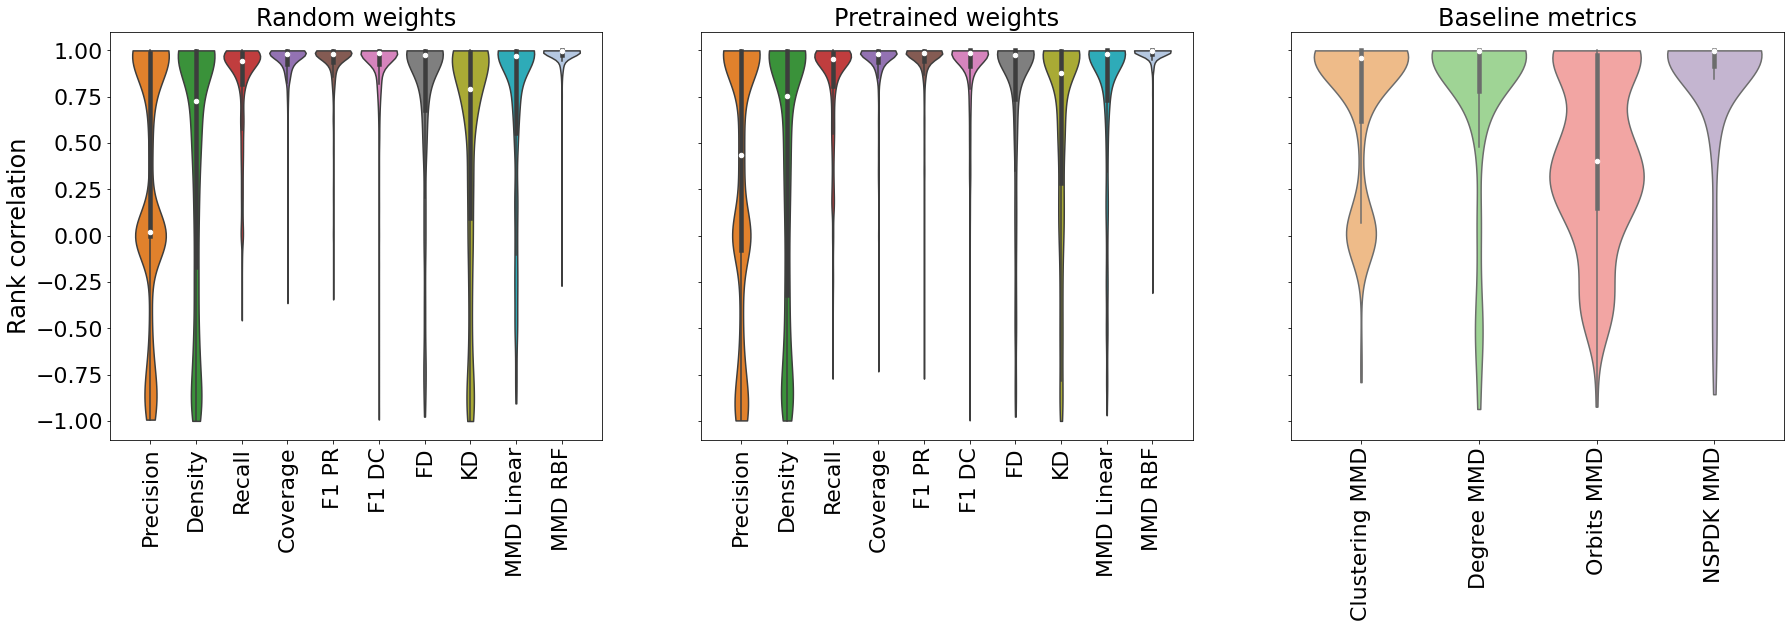

In [137]:
path = os.path.join(base_path, 'all_experiments', 'group_by_metric_all_datasets.pdf')
plot_original_three(experiments, datasets)#, configs=['N: 35, P: 3, G: 70'])#, path=path)

mixing-random
['mmd_rbf_quadratic_adaptive' 'density' 'recall' 'fid' 'f1_dc' 'kid'
 'f1_pr' 'precision' 'coverage' 'mmd_linear'] metricmetric
['precision', 'density', 'recall', 'coverage', 'f1_pr', 'f1_dc', 'fid', 'kid', 'mmd_linear', 'mmd_rbf_quadratic_adaptive'] metric
['mmd_rbf_quadratic_adaptive' 'density' 'recall' 'fid' 'f1_dc' 'kid'
 'f1_pr' 'precision' 'coverage' 'mmd_linear'] metricmetric
['precision', 'density', 'recall', 'coverage', 'f1_pr', 'f1_dc', 'fid', 'kid', 'mmd_linear', 'mmd_rbf_quadratic_adaptive'] metric
['clustering_mmd' 'orbits_mmd' 'degree_mmd' 'nspdk_mmd'] metricmetric
['clustering_mmd', 'degree_mmd', 'orbits_mmd', 'nspdk_mmd'] metric


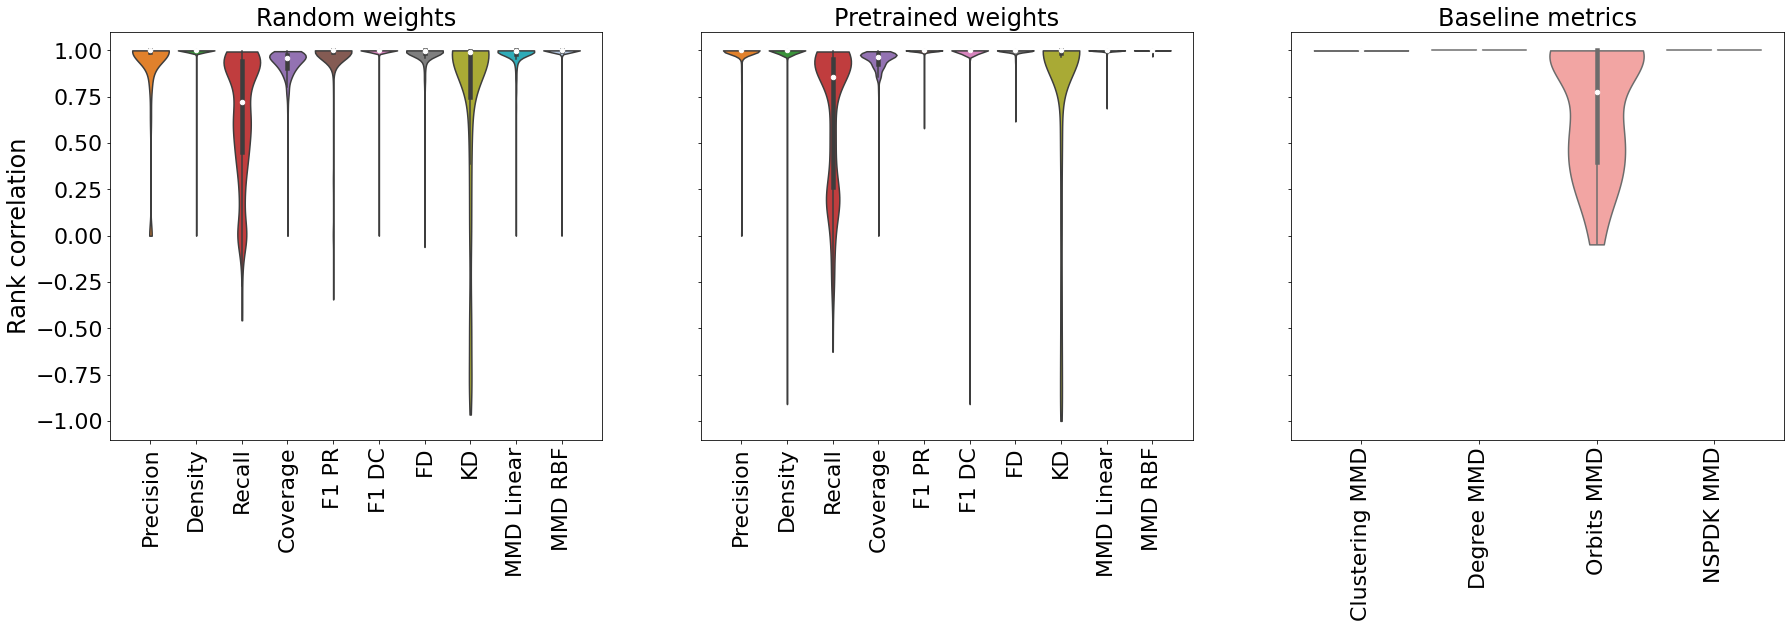

paper/paper-figures2/mixing-random/group_by_metric_all_datasets_3.pdf
mode-dropping
['mmd_rbf_quadratic_adaptive' 'density' 'recall' 'fid' 'f1_dc' 'kid'
 'f1_pr' 'precision' 'coverage' 'mmd_linear'] metricmetric
['precision', 'density', 'recall', 'coverage', 'f1_pr', 'f1_dc', 'fid', 'kid', 'mmd_linear', 'mmd_rbf_quadratic_adaptive'] metric
['mmd_rbf_quadratic_adaptive' 'density' 'recall' 'fid' 'f1_dc' 'kid'
 'f1_pr' 'precision' 'coverage' 'mmd_linear'] metricmetric
['precision', 'density', 'recall', 'coverage', 'f1_pr', 'f1_dc', 'fid', 'kid', 'mmd_linear', 'mmd_rbf_quadratic_adaptive'] metric
['clustering_mmd' 'orbits_mmd' 'degree_mmd' 'nspdk_mmd'] metricmetric
['clustering_mmd', 'degree_mmd', 'orbits_mmd', 'nspdk_mmd'] metric


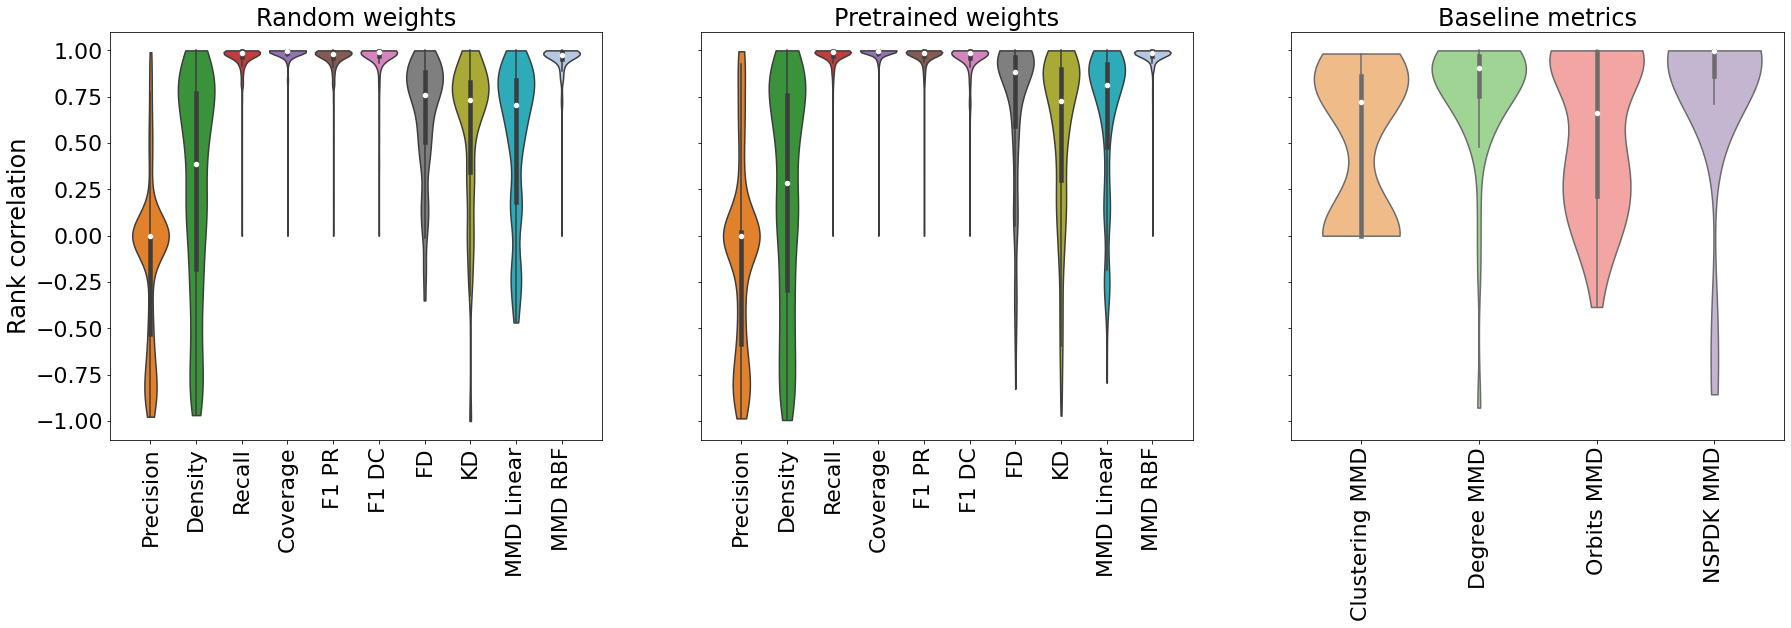

paper/paper-figures2/mode-dropping/group_by_metric_all_datasets_3.pdf
mode-collapse
['mmd_rbf_quadratic_adaptive' 'density' 'recall' 'fid' 'f1_dc' 'kid'
 'f1_pr' 'precision' 'coverage' 'mmd_linear'] metricmetric
['precision', 'density', 'recall', 'coverage', 'f1_pr', 'f1_dc', 'fid', 'kid', 'mmd_linear', 'mmd_rbf_quadratic_adaptive'] metric
['mmd_rbf_quadratic_adaptive' 'density' 'recall' 'fid' 'f1_dc' 'kid'
 'f1_pr' 'precision' 'coverage' 'mmd_linear'] metricmetric
['precision', 'density', 'recall', 'coverage', 'f1_pr', 'f1_dc', 'fid', 'kid', 'mmd_linear', 'mmd_rbf_quadratic_adaptive'] metric
['clustering_mmd' 'orbits_mmd' 'degree_mmd' 'nspdk_mmd'] metricmetric
['clustering_mmd', 'degree_mmd', 'orbits_mmd', 'nspdk_mmd'] metric


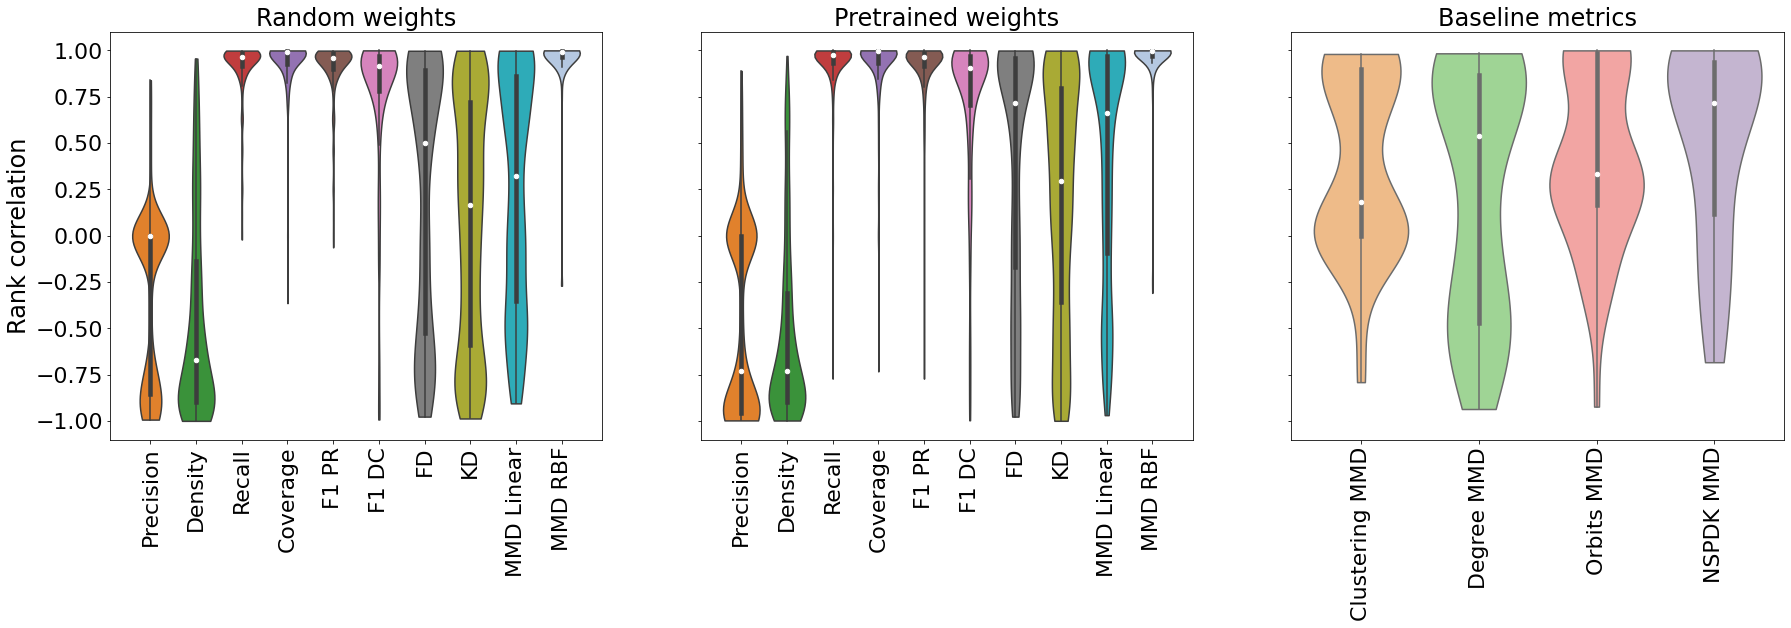

paper/paper-figures2/mode-collapse/group_by_metric_all_datasets_3.pdf
rewiring-edges
['mmd_rbf_quadratic_adaptive' 'density' 'recall' 'fid' 'f1_dc' 'kid'
 'f1_pr' 'precision' 'coverage' 'mmd_linear'] metricmetric
['precision', 'density', 'recall', 'coverage', 'f1_pr', 'f1_dc', 'fid', 'kid', 'mmd_linear', 'mmd_rbf_quadratic_adaptive'] metric
['mmd_rbf_quadratic_adaptive' 'density' 'recall' 'fid' 'f1_dc' 'kid'
 'f1_pr' 'precision' 'coverage' 'mmd_linear'] metricmetric
['precision', 'density', 'recall', 'coverage', 'f1_pr', 'f1_dc', 'fid', 'kid', 'mmd_linear', 'mmd_rbf_quadratic_adaptive'] metric
['clustering_mmd' 'orbits_mmd' 'degree_mmd' 'nspdk_mmd'] metricmetric
['clustering_mmd', 'degree_mmd', 'orbits_mmd', 'nspdk_mmd'] metric


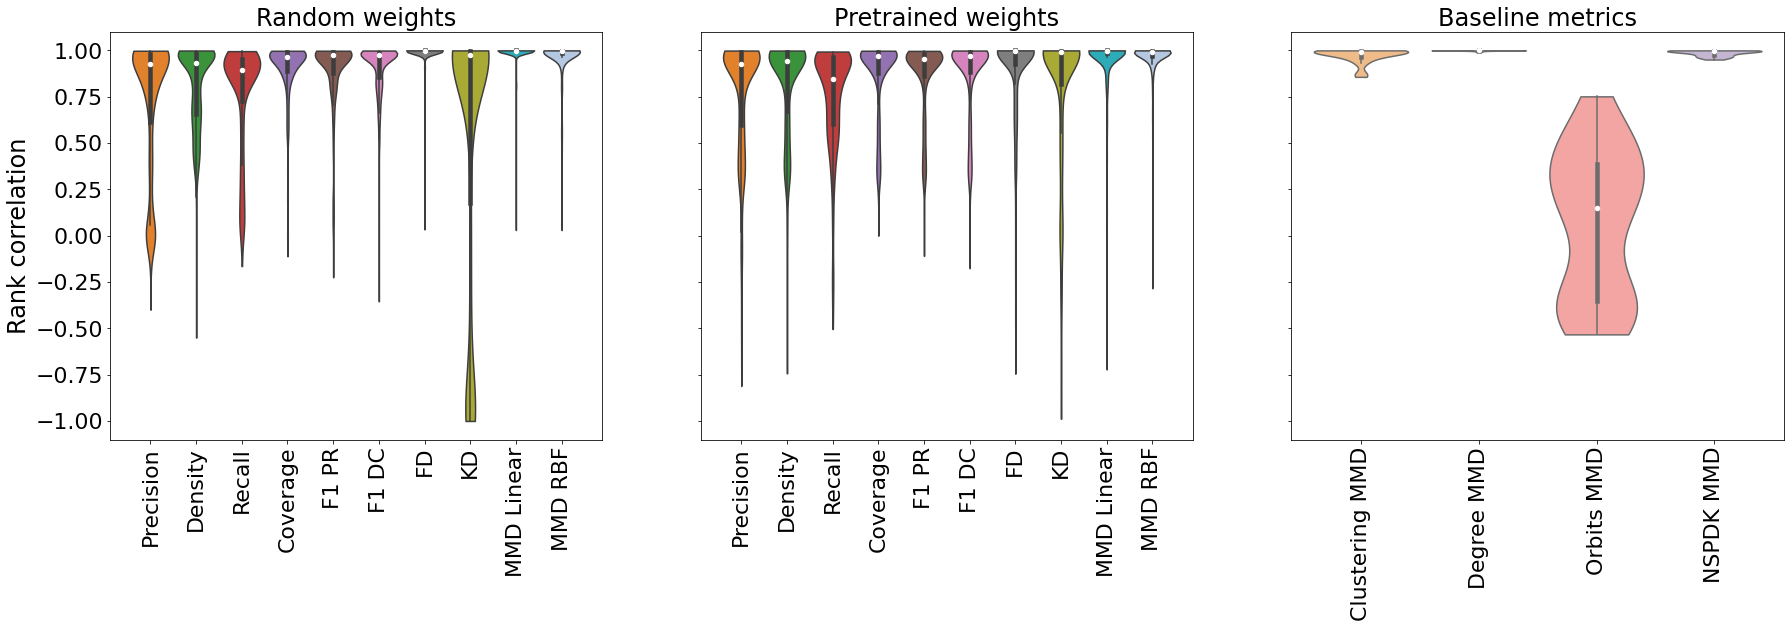

paper/paper-figures2/rewiring-edges/group_by_metric_all_datasets_3.pdf
sample-size-random
['mmd_rbf_quadratic_adaptive' 'density' 'recall' 'fid' 'f1_dc' 'kid'
 'f1_pr' 'precision' 'coverage' 'mmd_linear'] metricmetric
['precision', 'density', 'recall', 'coverage', 'f1_pr', 'f1_dc', 'fid', 'kid', 'mmd_linear', 'mmd_rbf_quadratic_adaptive'] metric
['mmd_rbf_quadratic_adaptive' 'density' 'recall' 'fid' 'f1_dc' 'kid'
 'f1_pr' 'precision' 'coverage' 'mmd_linear'] metricmetric
['precision', 'density', 'recall', 'coverage', 'f1_pr', 'f1_dc', 'fid', 'kid', 'mmd_linear', 'mmd_rbf_quadratic_adaptive'] metric
['clustering_mmd' 'orbits_mmd' 'degree_mmd' 'nspdk_mmd'] metricmetric
['clustering_mmd', 'degree_mmd', 'orbits_mmd', 'nspdk_mmd'] metric


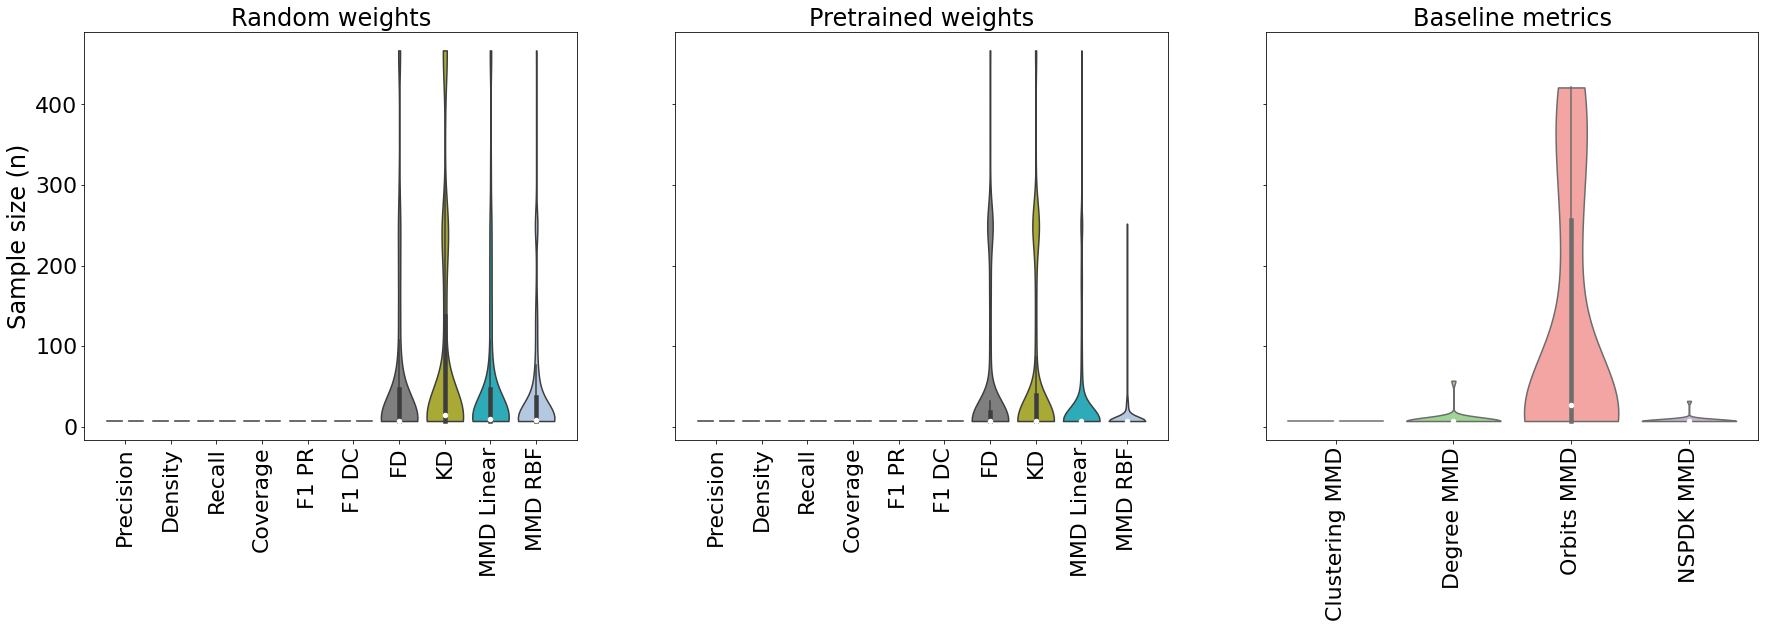

paper/paper-figures2/sample-size-random/group_by_metric_all_datasets_3.pdf


In [138]:

for exp in experiments + ['sample-size-random']:
    print(exp)
    path = os.path.join(base_path, exp, 'group_by_metric_all_datasets_3.pdf')
    plot_original_three([exp], datasets, path=path)#, configs=['N: 35, P: 3, G: 70'])#, path=path)

In [480]:
datasets

['proteins', 'lobster', 'grid', 'ego', 'community']

proteins
['precision', 'density', 'recall', 'coverage', 'f1_pr', 'f1_dc', 'fid', 'kid', 'mmd_linear', 'mmd_rbf_quadratic_adaptive'] metric
['precision', 'density', 'recall', 'coverage', 'f1_pr', 'f1_dc', 'fid', 'kid', 'mmd_linear', 'mmd_rbf_quadratic_adaptive'] metric
['wl_mmd', 'clustering_mmd', 'degree_mmd', 'orbits_mmd'] metric


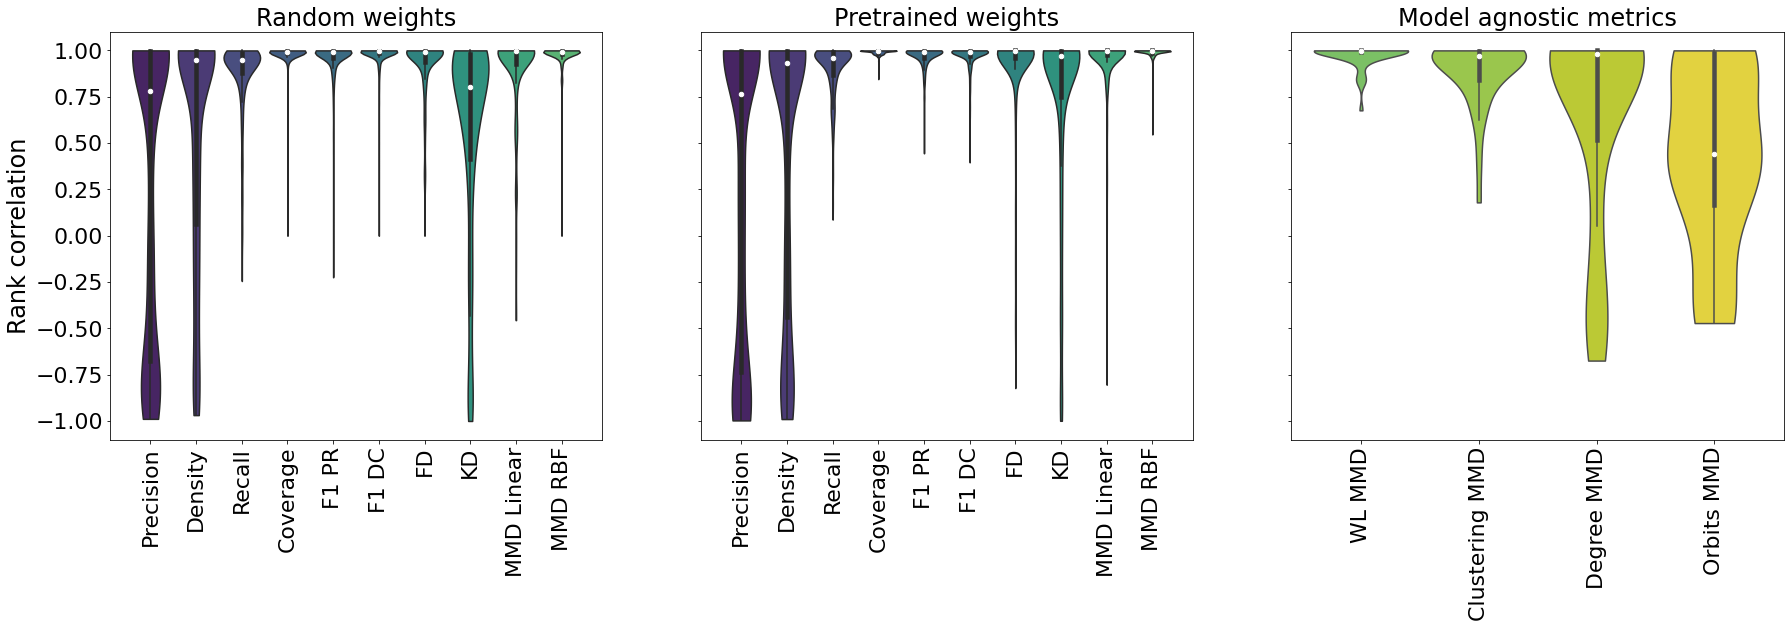

lobster
['precision', 'density', 'recall', 'coverage', 'f1_pr', 'f1_dc', 'fid', 'kid', 'mmd_linear', 'mmd_rbf_quadratic_adaptive'] metric
['precision', 'density', 'recall', 'coverage', 'f1_pr', 'f1_dc', 'fid', 'kid', 'mmd_linear', 'mmd_rbf_quadratic_adaptive'] metric
['wl_mmd', 'clustering_mmd', 'degree_mmd', 'orbits_mmd'] metric


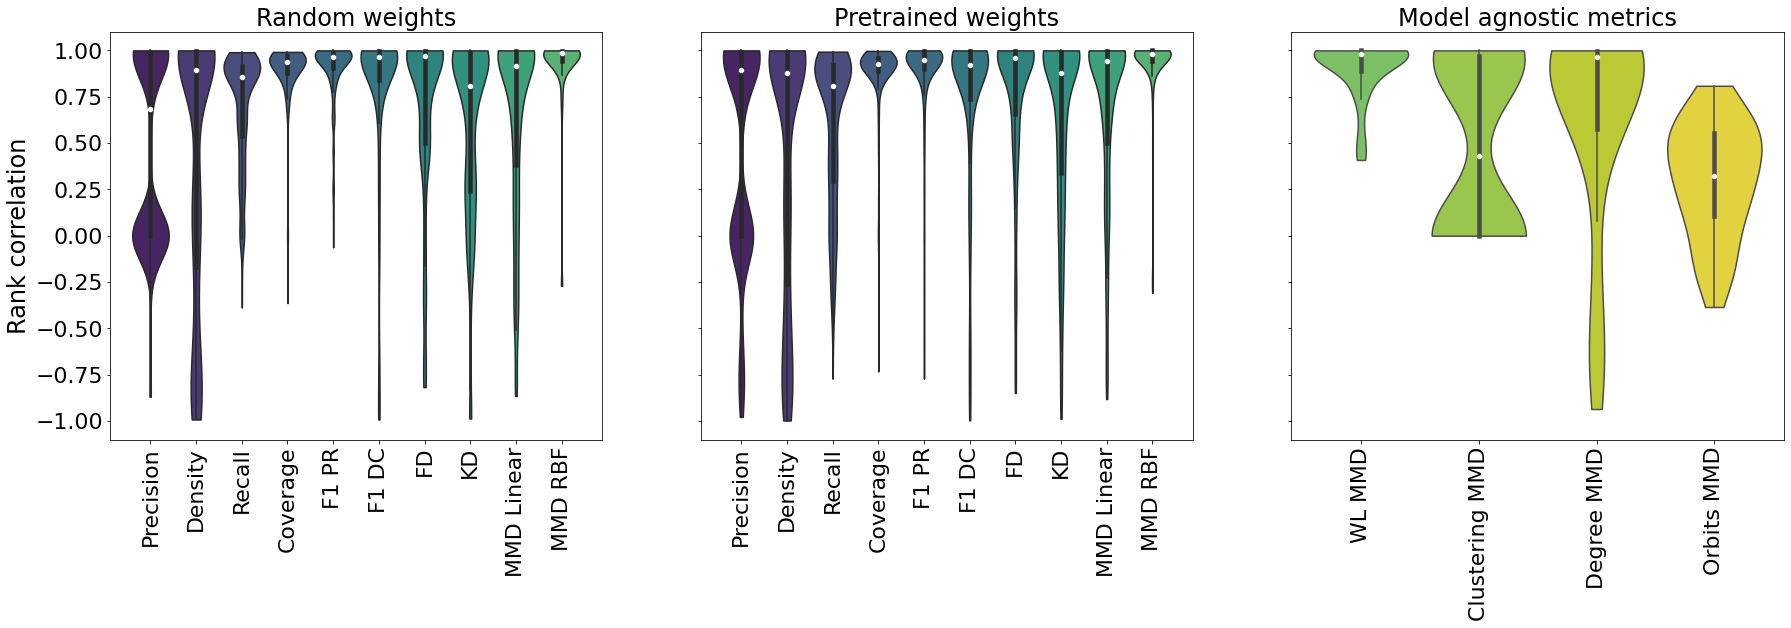

grid
['precision', 'density', 'recall', 'coverage', 'f1_pr', 'f1_dc', 'fid', 'kid', 'mmd_linear', 'mmd_rbf_quadratic_adaptive'] metric
['precision', 'density', 'recall', 'coverage', 'f1_pr', 'f1_dc', 'fid', 'kid', 'mmd_linear', 'mmd_rbf_quadratic_adaptive'] metric
['wl_mmd', 'clustering_mmd', 'degree_mmd', 'orbits_mmd'] metric


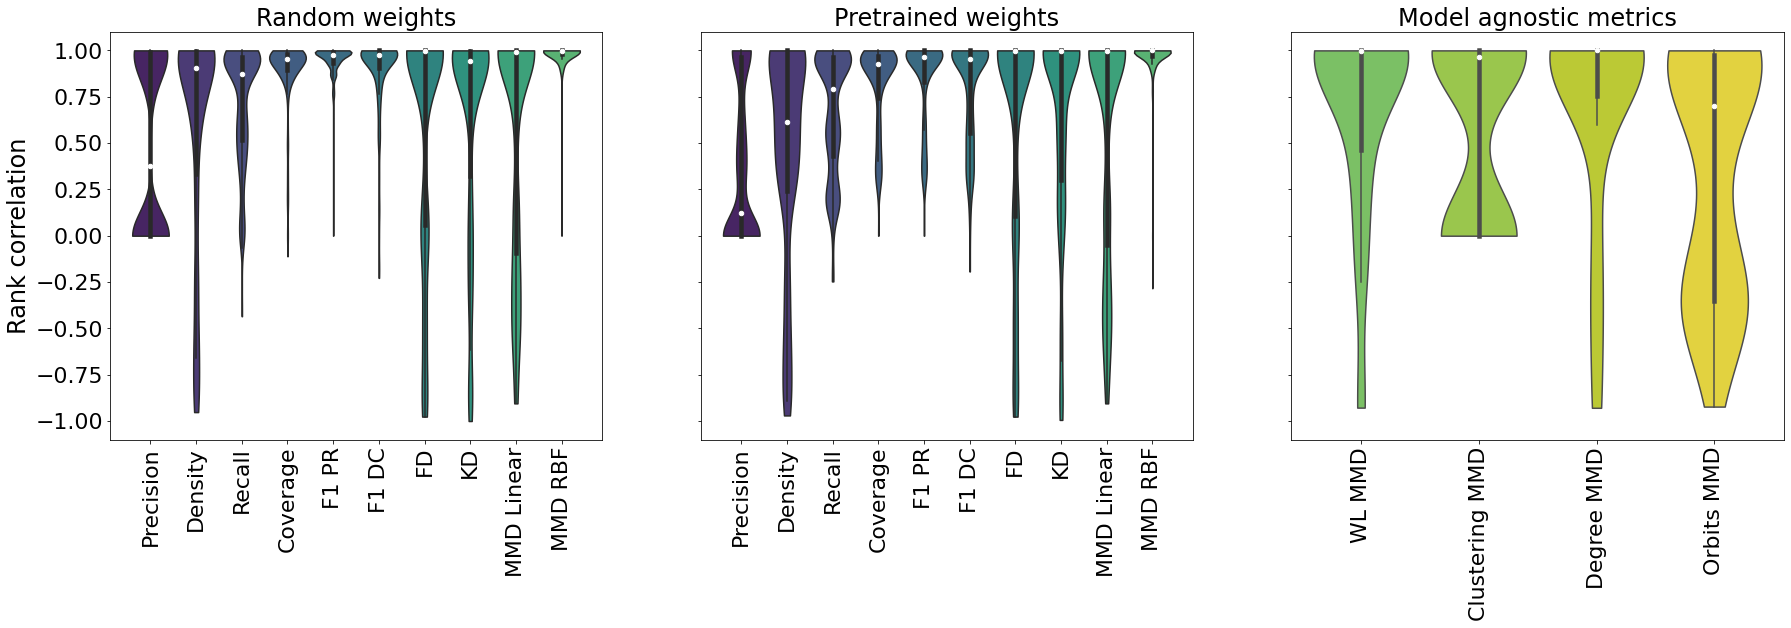

ego
['precision', 'density', 'recall', 'coverage', 'f1_pr', 'f1_dc', 'fid', 'kid', 'mmd_linear', 'mmd_rbf_quadratic_adaptive'] metric
['precision', 'density', 'recall', 'coverage', 'f1_pr', 'f1_dc', 'fid', 'kid', 'mmd_linear', 'mmd_rbf_quadratic_adaptive'] metric
['wl_mmd', 'clustering_mmd', 'degree_mmd', 'orbits_mmd'] metric


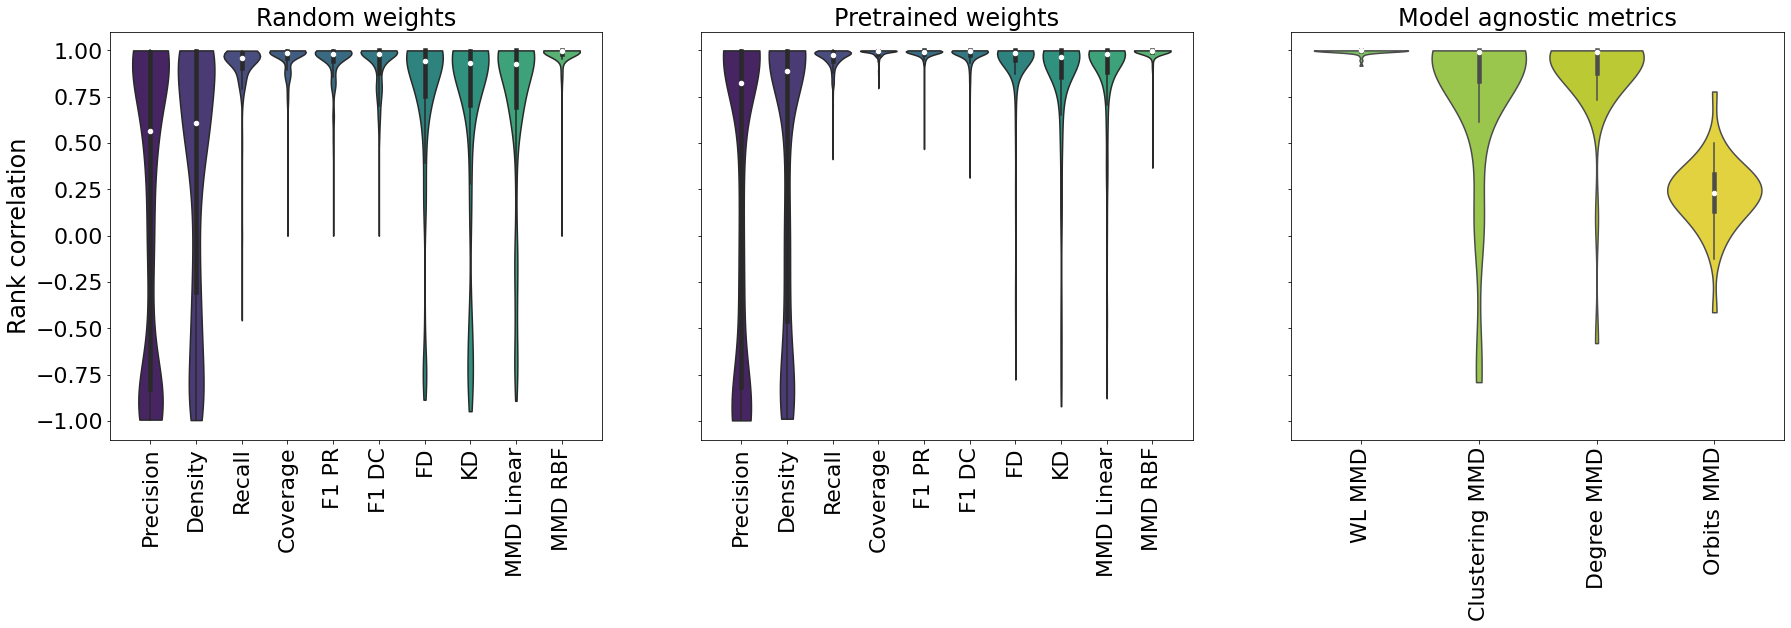

community
['precision', 'density', 'recall', 'coverage', 'f1_pr', 'f1_dc', 'fid', 'kid', 'mmd_linear', 'mmd_rbf_quadratic_adaptive'] metric
['precision', 'density', 'recall', 'coverage', 'f1_pr', 'f1_dc', 'fid', 'kid', 'mmd_linear', 'mmd_rbf_quadratic_adaptive'] metric
['wl_mmd', 'clustering_mmd', 'degree_mmd', 'orbits_mmd'] metric


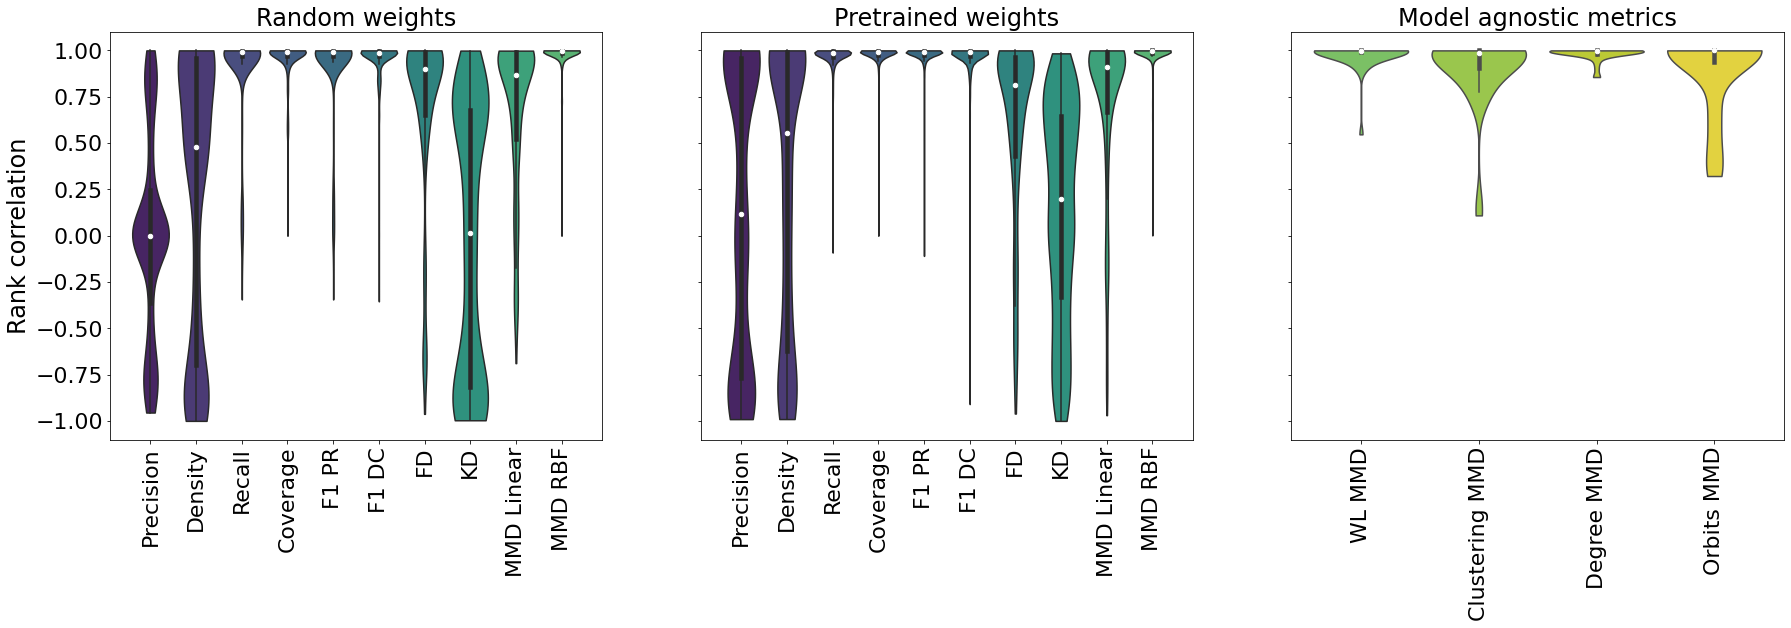

zinc
['precision', 'density', 'recall', 'coverage', 'f1_pr', 'f1_dc', 'fid', 'kid', 'mmd_linear', 'mmd_rbf_quadratic_adaptive'] metric
['precision', 'density', 'recall', 'coverage', 'f1_pr', 'f1_dc', 'fid', 'kid', 'mmd_linear', 'mmd_rbf_quadratic_adaptive'] metric


KeyError: 'precision'

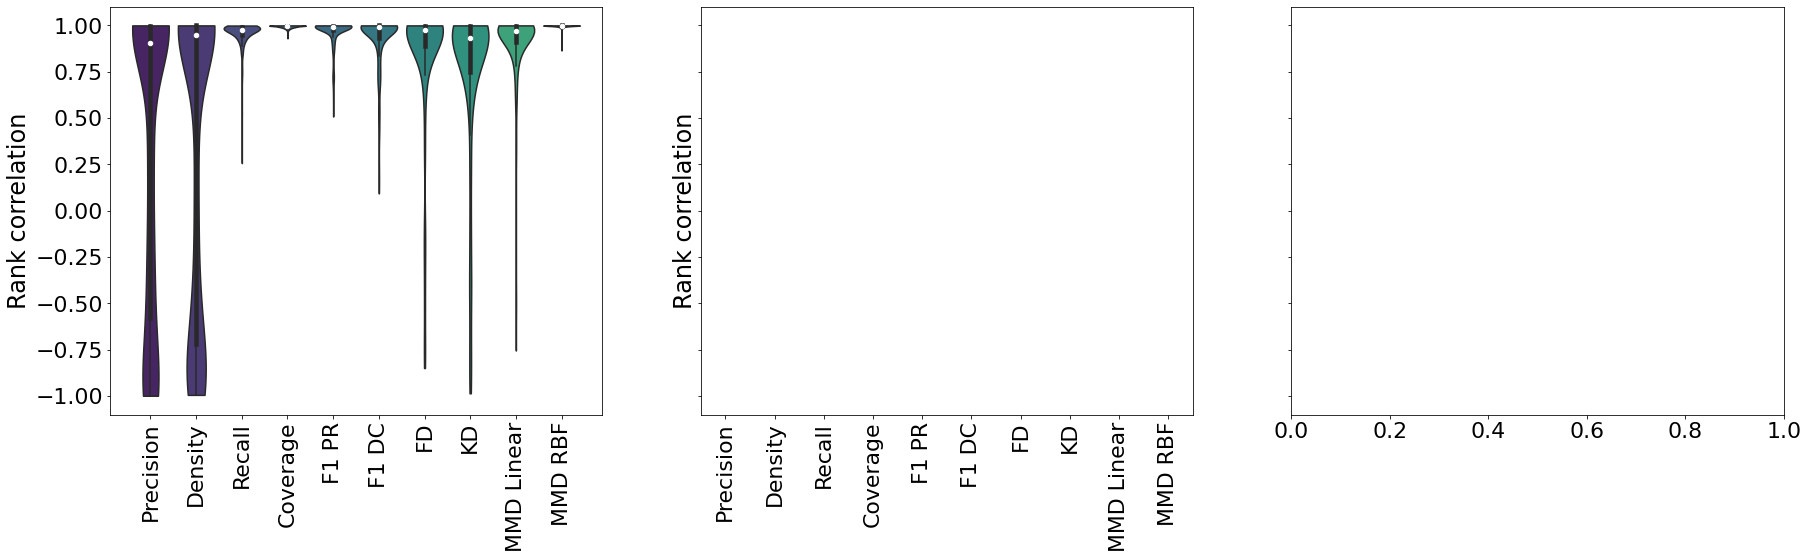

In [56]:
for dataset in datasets:# + ['zinc']:
    print(dataset)
#     path = 'paper/paper-figures2/'
    plot_original_three(experiments, [dataset])#, configs=['N: 35, P: 3, G: 70'])#, path=path)    

In [23]:
def get_experiment_title(experiment):
    if 'sample-size' not in experiment:
        exp = experiment.split('-')
        exp[0] = exp[0].title()
        exp = ' '.join(exp)
        return exp
    else:
        return 'Sample efficiency'
    
def plot_color_coded_single(experiment, datasets, **kwargs):
    fig, axes = plt.subplots(figsize=(13.5, 5))
    
    metrics = kwargs.get('metrics', to_plot[1:])
    plot_results(axes, experiment, datasets, metrics=metrics)
    axes.set_title(get_experiment_title(experiment[0]))
    
    if experiment[0] == 'rewiring-edges' or experiment[0] == 'mode-dropping':
        axes.set_yticklabels([])
        axes.set_ylabel('')
    
    if 'mode' in experiment[0]:
        axes.set_xticklabels([])
    
    if kwargs.get('path', None) is not None:
        print(path)
        fig.savefig(path, bbox_inches='tight')

['precision', 'density', 'recall', 'coverage', 'f1_pr', 'f1_dc', 'fid', 'kid', 'mmd_linear', 'mmd_rbf_quadratic_adaptive', 'wl_mmd', 'clustering_mmd', 'degree_mmd', 'orbits_mmd'] metric
paper/paper-figures2/mixing-random/group_by_metric_all_datasets_cc.pdf
['precision', 'density', 'recall', 'coverage', 'f1_pr', 'f1_dc', 'fid', 'kid', 'mmd_linear', 'mmd_rbf_quadratic_adaptive', 'wl_mmd', 'clustering_mmd', 'degree_mmd', 'orbits_mmd'] metric
paper/paper-figures2/mode-dropping/group_by_metric_all_datasets_cc.pdf
['precision', 'density', 'recall', 'coverage', 'f1_pr', 'f1_dc', 'fid', 'kid', 'mmd_linear', 'mmd_rbf_quadratic_adaptive', 'wl_mmd', 'clustering_mmd', 'degree_mmd', 'orbits_mmd'] metric
paper/paper-figures2/mode-collapse/group_by_metric_all_datasets_cc.pdf
['precision', 'density', 'recall', 'coverage', 'f1_pr', 'f1_dc', 'fid', 'kid', 'mmd_linear', 'mmd_rbf_quadratic_adaptive', 'wl_mmd', 'clustering_mmd', 'degree_mmd', 'orbits_mmd'] metric
paper/paper-figures2/rewiring-edges/group_b

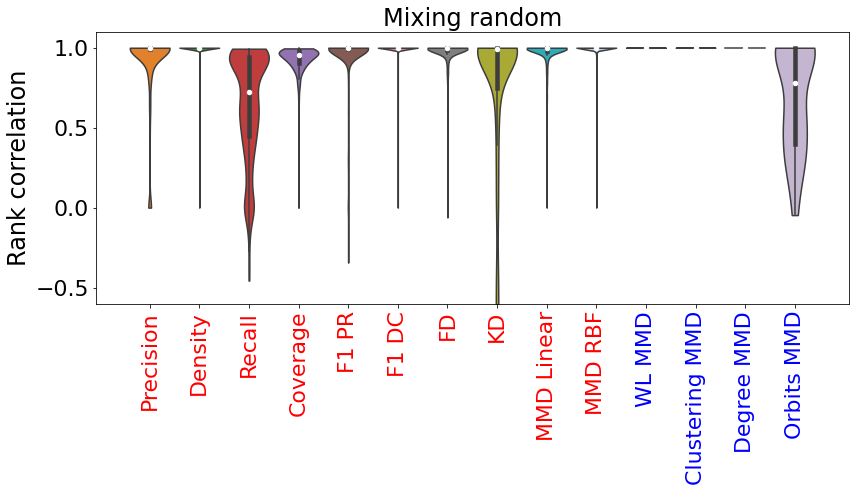

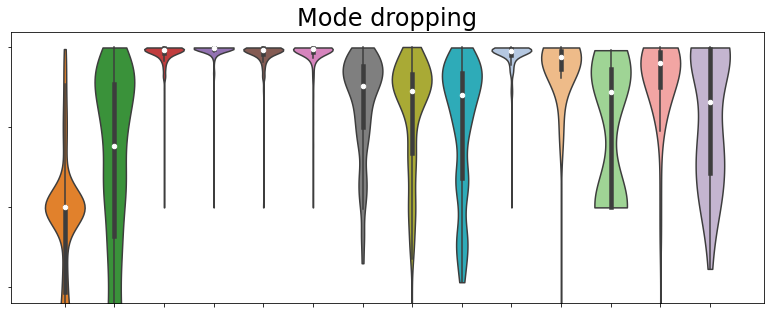

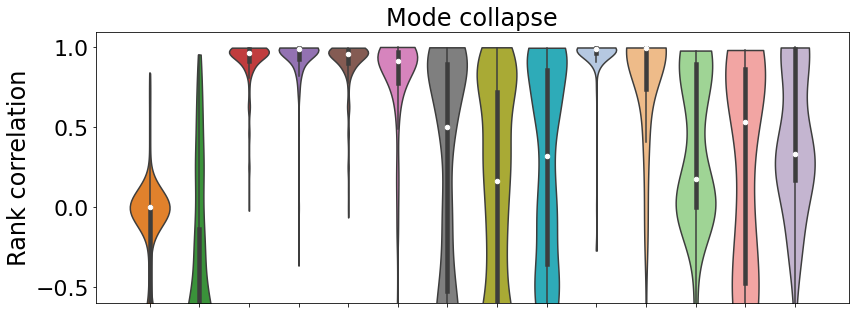

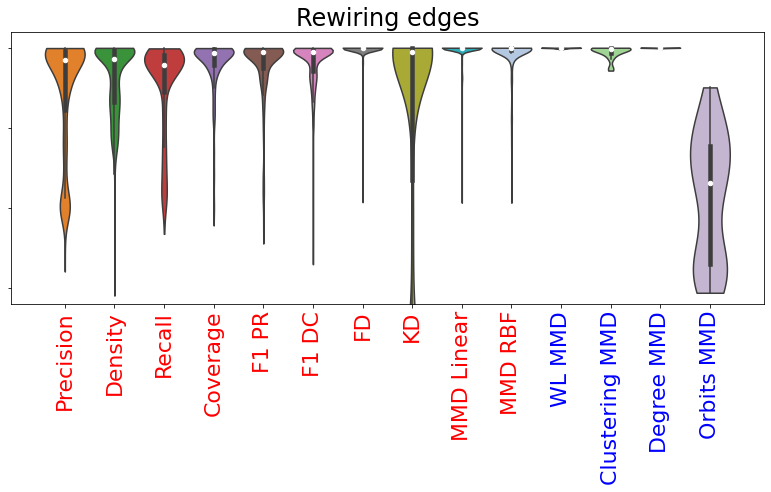

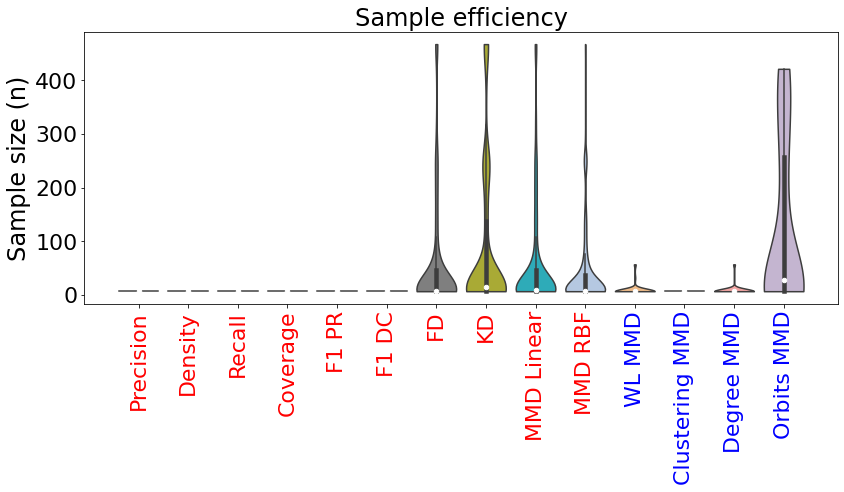

In [301]:
for exp in experiments + ['sample-size-random']:
    path = os.path.join(base_path, exp, 'group_by_metric_all_datasets_cc.pdf')
    plot_color_coded_single([exp], datasets, path=path)

['mmd_rbf_quadratic_adaptive' 'density' 'recall' 'fid' 'f1_dc' 'kid'
 'f1_pr' 'precision' 'coverage' 'mmd_linear' 'mmd_rbf_quadratic_single'
 'clustering_mmd' 'orbits_mmd' 'degree_mmd' 'nspdk_mmd'] metricmetric
['precision', 'density', 'recall', 'coverage', 'f1_pr', 'f1_dc', 'fid', 'kid', 'mmd_linear', 'mmd_rbf_quadratic_adaptive', 'mmd_rbf_quadratic_single', 'clustering_mmd', 'degree_mmd', 'orbits_mmd', 'nspdk_mmd'] metric
['mmd_rbf_quadratic_adaptive' 'density' 'recall' 'fid' 'f1_dc' 'kid'
 'f1_pr' 'precision' 'coverage' 'mmd_linear' 'mmd_rbf_quadratic_single'
 'clustering_mmd' 'orbits_mmd' 'degree_mmd' 'nspdk_mmd'] metricmetric
['precision', 'density', 'recall', 'coverage', 'f1_pr', 'f1_dc', 'fid', 'kid', 'mmd_linear', 'mmd_rbf_quadratic_adaptive', 'mmd_rbf_quadratic_single', 'clustering_mmd', 'degree_mmd', 'orbits_mmd', 'nspdk_mmd'] metric
mmd_rbf_quadratic_single not in ls


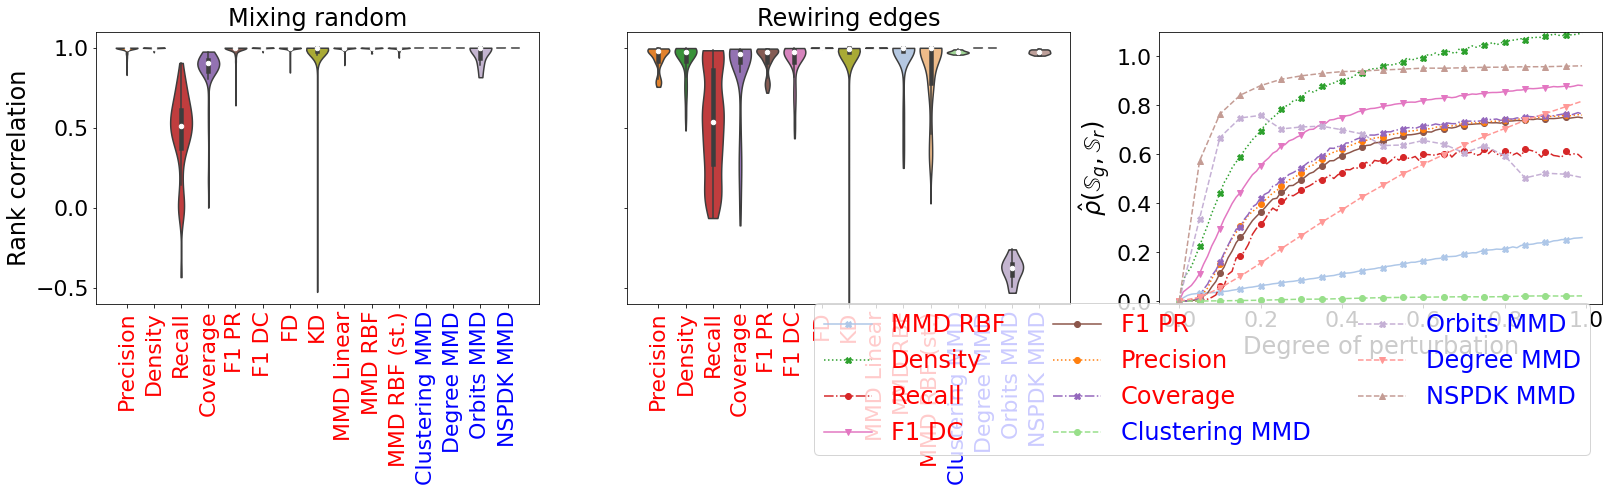

In [76]:
fig, axes = plt.subplots(1, 3, figsize=(27, 5))

exp = 'diversity'
if exp == 'fidelity':
    exps = ['mixing-random', 'rewiring-edges']
else:
    exps = ['mode-collapse', 'mode-dropping']

# metrics = kwargs.get('metrics', plot_metrics)
metrics = to_plot[1:]
plot_results(axes[0], [exps[0]], datasets, metrics=metrics)
axes[0].set_title(get_experiment_title(exps[0]))
plot_results(axes[1], [exps[1]], datasets, metrics=metrics)
axes[1].set_title(get_experiment_title(exps[1]))

axes[1].set_ylabel('')
axes[1].set_yticklabels([])

plot_line_plot(axes[2], [exps[1]], datasets)

# if exp == 'fidelity':
fig.savefig(f'paper/paper-figures2/{exp}.pdf', bbox_inches='tight')


In [8]:
def plot_random_pretrained(experiments, datasets, **kwargs):
    fig, axes = plt.subplots(1, 2, figsize=(30, 7.5), sharey=True)
    
    plot_results(axes[0], experiments, datasets, metrics=gin_metrics, **kwargs)
    plot_results(axes[1], experiments, datasets, metrics=gin_metrics, init='default', pretrained=True, **kwargs)
    
    axes[0].set_title('Random weights')
    axes[1].set_title('Pretrained weights')
    
    for ax in axes[1:]:
        ax.set_ylabel('')
        
    plt.show()
    
    if kwargs.get('path', None) is not None:
        print(path)
        fig.savefig(path, bbox_inches='tight')

['mmd_rbf_quadratic_adaptive' 'density' 'recall' 'fid' 'f1_dc' 'kid'
 'f1_pr' 'precision' 'coverage' 'mmd_linear' 'nspdk_mmd'] metricmetric
['precision', 'density', 'recall', 'coverage', 'f1_pr', 'f1_dc', 'fid', 'kid', 'mmd_linear', 'mmd_rbf_quadratic_adaptive', 'nspdk_mmd'] metric
paper/paper-figures2/randomize-nodes/group_by_metric_zinc_cc.pdf
['mmd_rbf_quadratic_adaptive' 'density' 'recall' 'fid' 'f1_dc' 'kid'
 'f1_pr' 'precision' 'coverage' 'mmd_linear' 'nspdk_mmd'] metricmetric
['precision', 'density', 'recall', 'coverage', 'f1_pr', 'f1_dc', 'fid', 'kid', 'mmd_linear', 'mmd_rbf_quadratic_adaptive', 'nspdk_mmd'] metric
paper/paper-figures2/randomize-edges/group_by_metric_zinc_cc.pdf


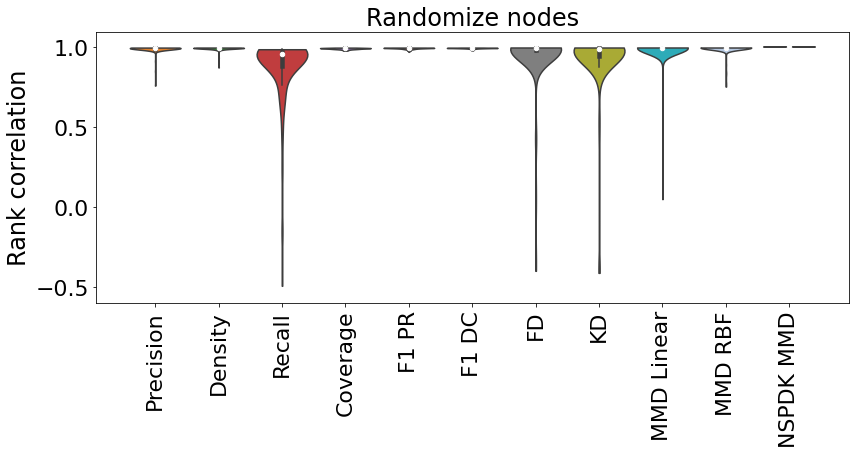

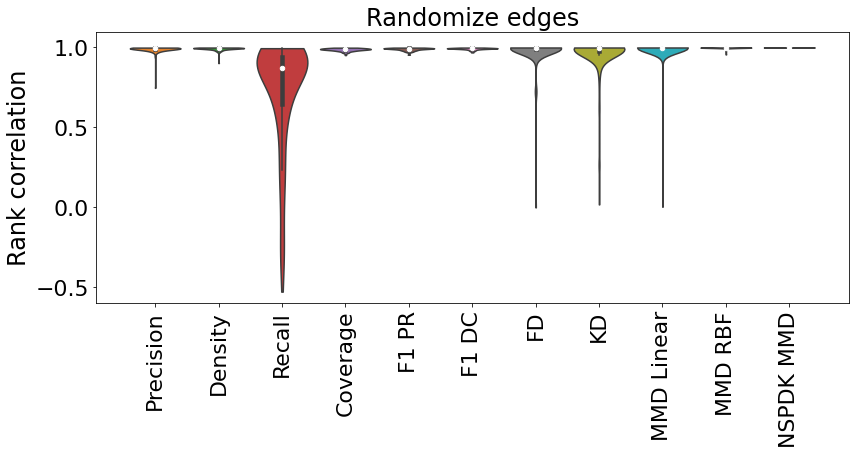

In [28]:
for exp in ['randomize-nodes', 'randomize-edges']:
    path = os.path.join(base_path, exp, 'group_by_metric_zinc_cc.pdf')
    plot_color_coded_single([exp], ['zinc'], metrics=[metric for metric in gin_metrics if metric in to_plot and metric != 'activations'] + ['nspdk_mmd'], path=path)

/home/rylee/python/pna/env/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  import sys
/home/rylee/python/pna/env/lib/python3.7/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.


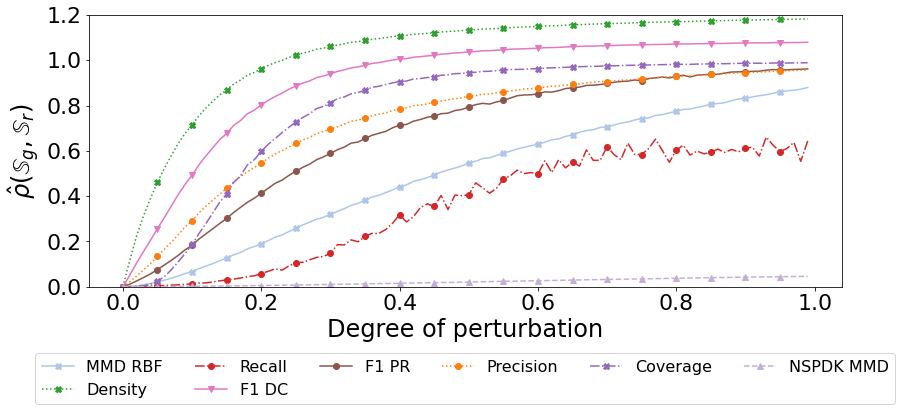

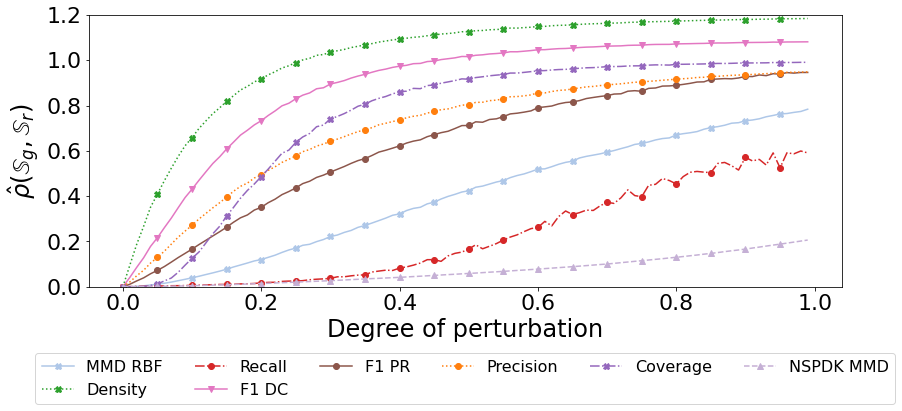

In [18]:
fig, axes = plt.subplots(figsize=(13.5, 5))
plot_line_plot(axes, ['randomize-edges'], ['zinc'], metrics=[metric for metric in gin_metrics if metric in to_plot] + ['nspdk_mmd'])
axes.set_ylim(0, 1.2)
#     # Get the bounding box of the original legend
leg = axes.legend(loc='lower center', ncol=6)

bb = leg.get_bbox_to_anchor().inverse_transformed(axes.transAxes)

# Change to location of the legend. 
# xOffset = 0.2 # Play with this to tweak position of legend
yOffset = 0.46 # Play with this to tweak position of legend
bb.y0 -= yOffset
bb.y1 -= yOffset
xOffset = 0
bb.x0 -= xOffset
bb.x1 -= xOffset
leg.set_bbox_to_anchor(bb, transform = axes.transAxes)

fig.savefig('paper/paper-figures2/randomize-edges/line_plot.pdf', bbox_inches='tight')

fig, axes = plt.subplots(figsize=(13.5, 5))
plot_line_plot(axes, ['randomize-nodes'], ['zinc'], metrics=[metric for metric in gin_metrics if metric in to_plot] + ['nspdk_mmd'])
axes.set_ylim(0, 1.2)
leg = axes.legend(loc='lower center', ncol=6)

bb = leg.get_bbox_to_anchor().inverse_transformed(axes.transAxes)

# Change to location of the legend. 
# xOffset = 0.2 # Play with this to tweak position of legend
yOffset = 0.46 # Play with this to tweak position of legend
bb.y0 -= yOffset
bb.y1 -= yOffset
xOffset = 0
bb.x0 -= xOffset
bb.x1 -= xOffset
leg.set_bbox_to_anchor(bb, transform = axes.transAxes)
fig.savefig('paper/paper-figures2/randomize-nodes/line_plot.pdf', bbox_inches='tight')

/home/rylee/python/pna/env/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  


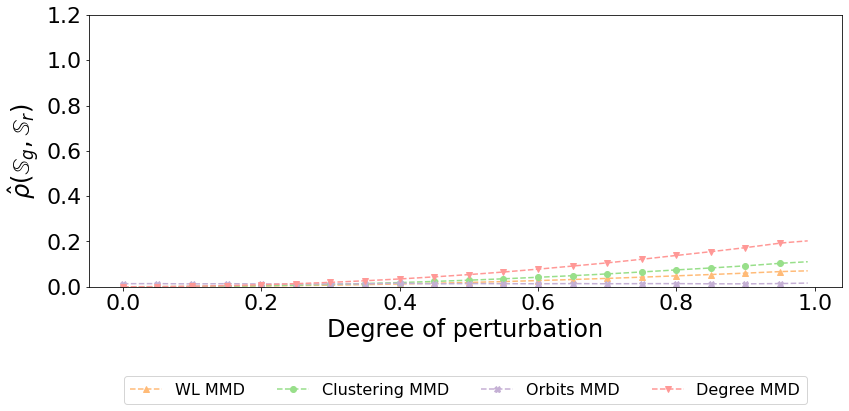

In [54]:
fig, axes = plt.subplots(figsize=(13.5, 5))
plot_line_plot(axes, ['mixing-gen'], datasets, metrics=mmd_metrics)
# plot_line_plot(axes, ['mixing-gen'], datasets, metrics=[metric for metric in gin_metrics if metric in to_plot])
axes.set_ylim(0, 1.2)
#     # Get the bounding box of the original legend
leg = axes.legend(loc='lower center', ncol=6)

bb = leg.get_bbox_to_anchor().inverse_transformed(axes.transAxes)

# Change to location of the legend. 
# xOffset = 0.2 # Play with this to tweak position of legend
yOffset = 0.46 # Play with this to tweak position of legend
bb.y0 -= yOffset
bb.y1 -= yOffset
xOffset = 0
bb.x0 -= xOffset
bb.x1 -= xOffset
leg.set_bbox_to_anchor(bb, transform = axes.transAxes)


['N: 25, P: 4, G: 75' 'N: 35, P: 3, G: 70' 'N: 20, P: 3, G: 40'
 'N: 25, P: 3, G: 50' 'N: 10, P: 3, G: 20' 'N: 30, P: 5, G: 120'
 'N: 20, P: 5, G: 80' 'N: 40, P: 5, G: 160' 'N: 35, P: 5, G: 140'
 'N: 5, P: 5, G: 20' 'N: 5, P: 7, G: 30' 'N: 15, P: 6, G: 75'
 'N: 10, P: 7, G: 60' 'N: 15, P: 7, G: 90' 'N: 20, P: 7, G: 120'
 'N: 40, P: 6, G: 200' 'N: 15, P: 2, G: 15' 'N: 40, P: 2, G: 40'
 'N: 10, P: 2, G: 10' 'N: 5, P: 2, G: 5'] config
['N: 20, P: 3, G: 40' 'N: 10, P: 7, G: 60' 'N: 25, P: 3, G: 50'
 'N: 5, P: 5, G: 20' 'N: 35, P: 3, G: 70' 'N: 20, P: 7, G: 120'
 'N: 40, P: 5, G: 160' 'N: 20, P: 5, G: 80' 'N: 5, P: 7, G: 30'
 'N: 30, P: 5, G: 120' 'N: 40, P: 2, G: 40' 'N: 15, P: 7, G: 90'
 'N: 15, P: 6, G: 75' 'N: 25, P: 4, G: 75' 'N: 10, P: 3, G: 20'
 'N: 40, P: 6, G: 200' 'N: 35, P: 5, G: 140' 'N: 10, P: 2, G: 10'
 'N: 15, P: 2, G: 15' 'N: 5, P: 2, G: 5'] config


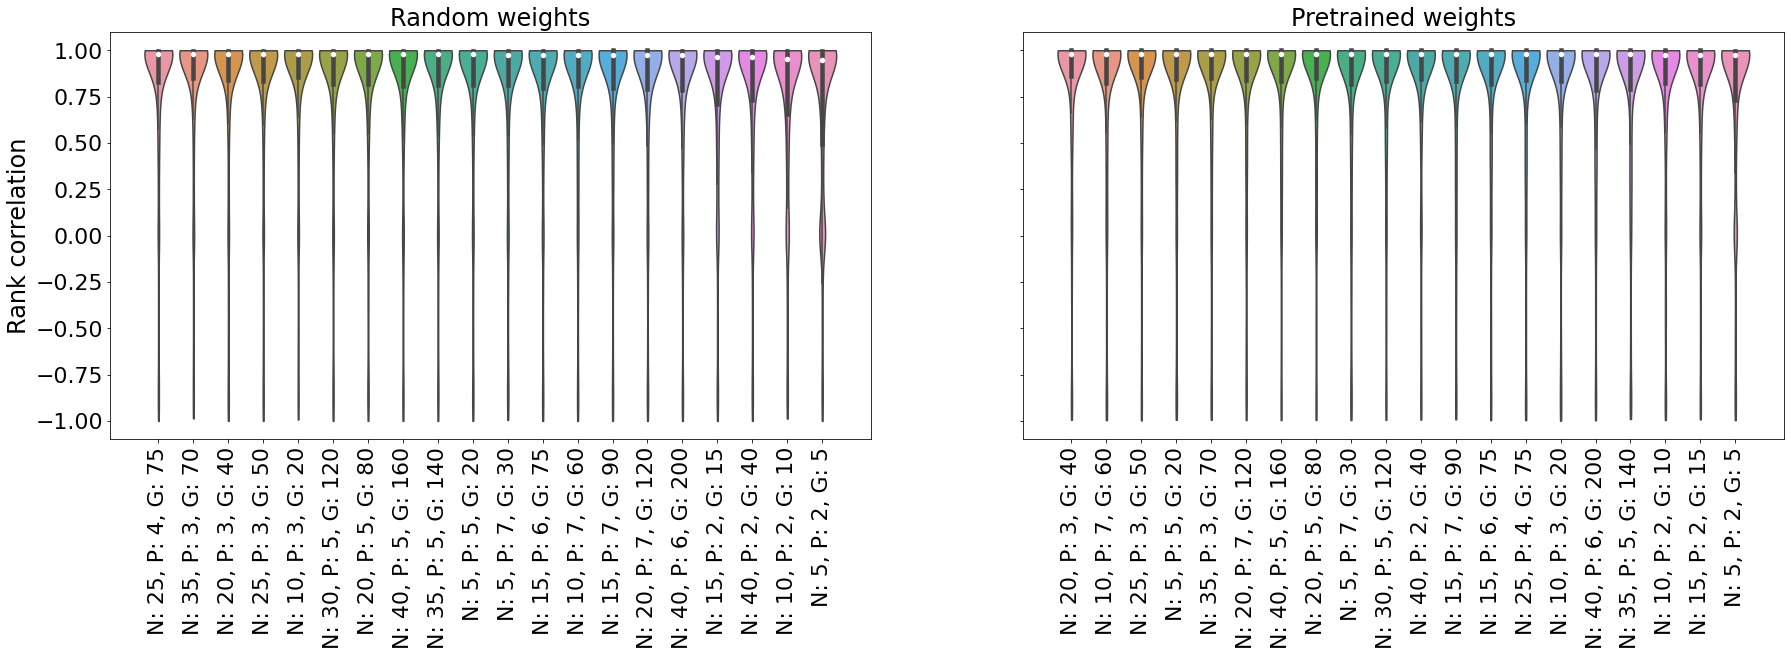

paper/paper-figures2/all_experiments/group_by_config_all_datasets.pdf
['N: 5, P: 7, G: 30, MMD RBF' 'N: 15, P: 6, G: 75, MMD RBF adapt.'
 'N: 15, P: 7, G: 90, MMD RBF' 'N: 15, P: 7, G: 90, MMD RBF adapt.'
 'N: 20, P: 5, G: 80, MMD RBF adapt.' 'N: 15, P: 6, G: 75, MMD RBF'
 'N: 10, P: 7, G: 60, MMD RBF adapt.' 'N: 5, P: 5, G: 20, MMD RBF'
 'N: 10, P: 7, G: 60, MMD RBF' 'N: 30, P: 5, G: 120, MMD RBF adapt.'
 'N: 20, P: 7, G: 120, MMD RBF adapt.' 'N: 10, P: 3, G: 20, MMD RBF'
 'N: 5, P: 5, G: 20, MMD RBF adapt.' 'N: 5, P: 7, G: 30, MMD RBF adapt.'
 'N: 20, P: 5, G: 80, MMD RBF' 'N: 25, P: 4, G: 75, MMD RBF'
 'N: 20, P: 3, G: 40, MMD RBF' 'N: 40, P: 5, G: 160, MMD RBF adapt.'
 'N: 25, P: 3, G: 50, MMD RBF' 'N: 35, P: 5, G: 140, MMD RBF adapt.'] config_metric
['N: 20, P: 7, G: 120, MMD RBF' 'N: 30, P: 5, G: 120, MMD RBF adapt.'
 'N: 15, P: 7, G: 90, MMD RBF adapt.'
 'N: 40, P: 6, G: 200, MMD RBF adapt.' 'N: 10, P: 7, G: 60, MMD RBF'
 'N: 10, P: 3, G: 20, MMD RBF adapt.' 'N: 20, P: 5, G: 80,

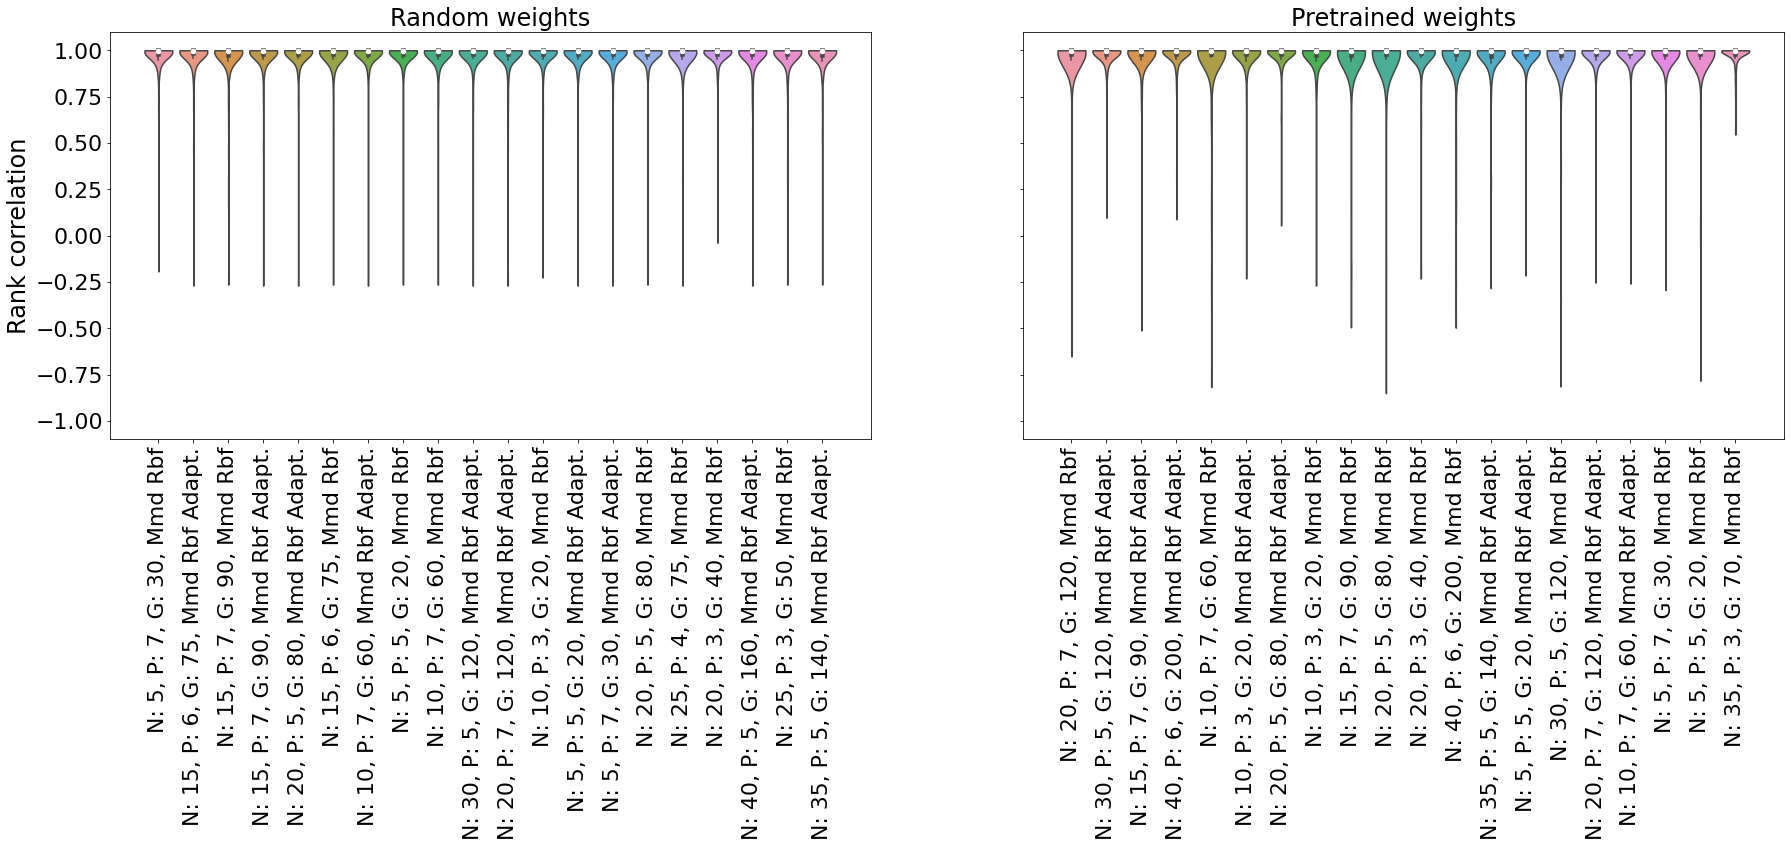

paper/paper-figures2/all_experiments/group_by_config_metric_all_datasets.pdf


In [16]:
path = os.path.join(base_path, 'all_experiments', 'group_by_config_all_datasets.pdf')
plot_random_pretrained(experiments, datasets, grouping='config', ordering='median', path=path)

path = os.path.join(base_path, 'all_experiments', 'group_by_config_metric_all_datasets.pdf')
plot_random_pretrained(experiments, datasets, grouping='config_metric', ordering='median', path=path, graph_top_k=20)

# Computation efficiency

/home/rylee/python/pna/env/lib/python3.7/site-packages/ipykernel_launcher.py:99: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/rylee/python/pna/env/lib/python3.7/site-packages/ipykernel_launcher.py:104: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.


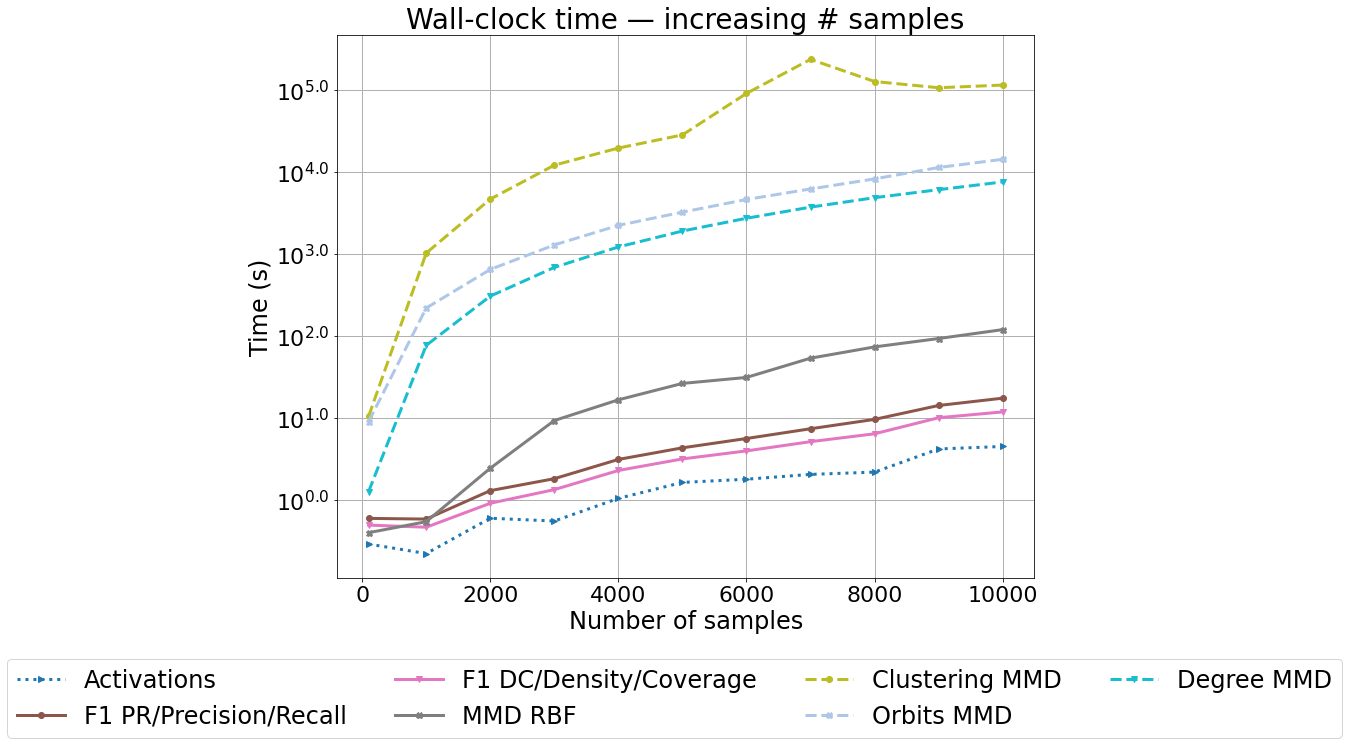

In [2]:
import matplotlib.pyplot as plt
from utils.experiment_logging import get_results, get_config
import os

linestyles = {'mmd_rbf_quadratic_adaptive': {'linestyle': '-', 'marker': 'X'},
              'f1_pr': {'linestyle': '-', 'marker': 'o'},
              'f1_dc': {'linestyle': '-', 'marker': 'v'},
              'coverage': {'linestyle': '-.', 'marker': 'X'},
              'recall': {'linestyle': '-.', 'marker': 'o'},
              'density': {'linestyle': ':', 'marker': 'X'},
              'precision': {'linestyle': ':', 'marker': 'o'},
              'orbits_mmd': {'linestyle': '--', 'marker': 'X'},
              'clustering_mmd': {'linestyle': '--', 'marker': 'o'},
              'degree_mmd': {'linestyle': '--', 'marker': 'v'},
              'wl_mmd': {'linestyle': '--', 'marker': '^'},
              'mmd_rbf_quadratic': {'linestyle': '-', 'marker': '>'},
              'activations': {'linestyle': ':', 'marker': '>'}
             }

# fig, axs = plt.subplots(1, 3, figsize=(30, 7.5), sharey=False)
fig, axs = plt.subplots(figsize=(12.5, 10), sharey=False) # To plot just comp-eff quantity
plot_cpu = True

exps = ['computation-eff-qty', 'computation-eff-edges', 'computation-eff-size']
# exps = ['computation-eff-qty', 'computation-eff-edges', 'computation-eff-size']
if type(axs) != np.ndarray:
    exps = exps[: 1]
    axs = [axs]

if len(exps) == 1:
    plt.rc('axes', titlesize=28) # 26     # fontsize of the axes title
else:
    plt.rc('axes', titlesize=24) # 26     # fontsize of the axes title
    

for ix, (ax, exp) in enumerate(zip(axs, exps)):  
    all_results = {}
        
    for root, subdir, files in os.walk(f'experiment_results/{exp}'):
        if 'results.h5' not in files:
            continue

        exp_results = get_results(run_dir=root)
        if len(exp_results) == 1:
            exp_results = exp_results[0]
            
        exp_config = get_config(run_dir=root)
        if exp_config['no_cuda'] != plot_cpu and exp_config['feature_extractor'] == 'gin':
            continue
        
        if ix == 0:
            removed_keys = ['precision', 'recall', 'density', 'coverage', 'mmd_rbf_linear', 'mmd_rbf_linear_adaptive'] + dont_plot# + ['activations']
        else:
            removed_keys = gin_metrics[1:]
            
        removed_keys = [key + '_time' for key in removed_keys]
        time_keys = [key for key in exp_results[0].keys() if '_time' in key and key not in removed_keys]
        for key in time_keys:
            all_results[key] = [iter_res[key] for iter_res in exp_results]

    if exp == 'computation-eff-edges':
        y = np.arange(0.1, 1.1, 0.1).tolist()
        y.insert(0, 0.01)
        y = np.array(y)
        y = y * (1000 ** 2) # Graph size = 1000
        title = 'Wall-clock time — increasing edges per graph'
        axis_label = 'Avg. number of edges per graph'

    elif exp == 'computation-eff-qty':
        y = np.arange(1000, 11000, 1000).tolist()
        y.insert(0, 100)
        title = 'Wall-clock time — increasing # samples'
        axis_label = 'Number of samples'

    elif exp == 'computation-eff-size':
        y = np.arange(10000, 110000, 10000).tolist()
        y.insert(0, 1000)
        title = 'Wall-clock time — increasing nodes per graph'
        axis_label = 'Avg. number of nodes per graph'

    for key, val in all_results.items():
        val = np.array(val)
        key = key[:-5]
        lw = 3
        
        if ix == 0 and should_plot(key):
            ax.plot(y[:len(val)], np.log10(val), label=get_label(key), color=get_color_qualitative(key), lw=lw, **linestyles[key])
            
        elif should_plot(key):
            ax.plot(y[:len(val)], np.log10(val), color=get_color_qualitative(key), lw=lw, **linestyles[key])
        
    if ix == 0:
        ax.set_ylabel('Time (s)')
        
    ax.set_title(title)
    ax.set_xlabel(axis_label)
    ax.grid(linewidth=1)
    ticks = ax.get_yticks()
    _ = ax.set_yticklabels(['$10^{' + str(tick) + '}$' for tick in ticks])
    
leg = fig.legend(loc='lower center', ncol=4)

# Get the bounding box of the original legend
bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)

# Change to location of the legend. 
# xOffset = 0.2 # Play with this to tweak position of legend
xOffset = -0 # Play with this to tweak position of legend
bb.x0 -= xOffset
bb.x1 -= xOffset

yOffset = 0.15 # Play with this to tweak position of legend
bb.y0 -= yOffset
bb.y1 -= yOffset
leg.set_bbox_to_anchor(bb, transform = ax.transAxes)

dev = 'gpu' if not plot_cpu else 'cpu'
if len(exps) > 1:
    fig.savefig(f'paper/paper-figures2/Computation-efficiency-all-{dev}.pdf', bbox_inches='tight')
    fig.savefig(f'paper/paper-figures2/Computation-efficiency-all-{dev}.jpg', bbox_inches='tight')
else:
    fig.savefig(f'paper/paper-figures2/Computation-efficiency-qty-{dev}.pdf', bbox_inches='tight')
    fig.savefig(f'paper/paper-figures2/Computation-efficiency-qty-{dev}.jpg', bbox_inches='tight')        

# Plot memory usage (basically copy + paste above)




computation-eff-qty activations_time 4.016267264
computation-eff-qty wl_mmd_time 12.890804224
computation-eff-qty clustering_mmd_time 1.263312896
computation-eff-qty orbits_mmd_time 1.198764032
computation-eff-qty degree_mmd_time 1.20846336



computation-eff-edges activations_time 10.402906112
computation-eff-edges wl_mmd_time 25.051123712
computation-eff-edges clustering_mmd_time 21.852618752
computation-eff-edges orbits_mmd_time 21.80425728
computation-eff-edges degree_mmd_time 21.87892736



computation-eff-size activations_time 4.082429952
computation-eff-size wl_mmd_time 9.754877952
computation-eff-size clustering_mmd_time 7.200956416
computation-eff-size orbits_mmd_time 7.207432192
computation-eff-size degree_mmd_time 7.199244288


/home/rylee/python/pna/env/lib/python3.7/site-packages/ipykernel_launcher.py:77: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.


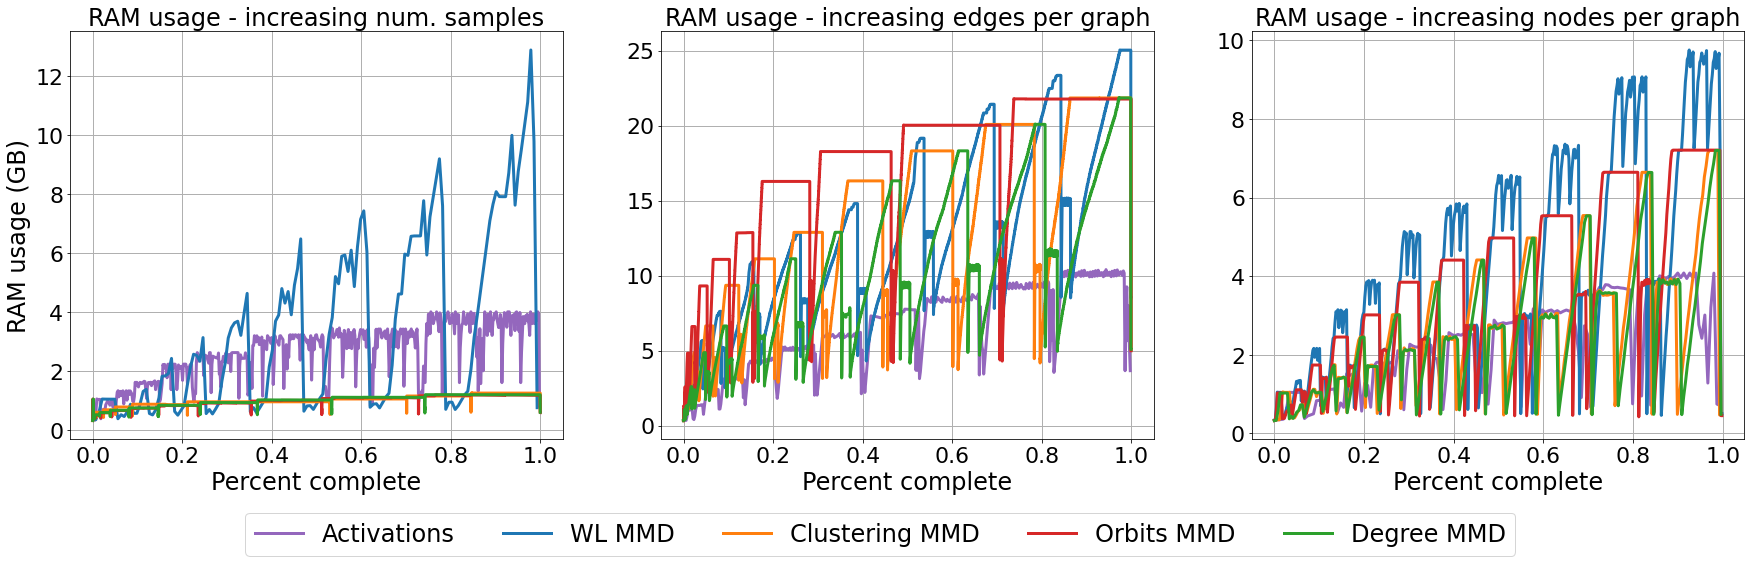

In [20]:
import matplotlib.pyplot as plt
from utils.experiment_logging import get_results, get_config, get_memory_usage
import os

fig, axs = plt.subplots(1, 3, figsize=(30, 7.5), sharey=False)
exps = ['computation-eff-qty', 'computation-eff-edges', 'computation-eff-size']
plot_cpu = True

for ix, (ax, exp) in enumerate(zip(axs, exps)):
    
    all_results = {}
    for root, subdir, files in os.walk(f'experiment_results/{exp}'):
        if 'memory.h5' not in files:
            continue
        exp_results = get_results(run_dir=root)
        memory_usage = get_memory_usage(run_dir=root)
        
        if len(exp_results) == 1:
            exp_results = exp_results[0]

        exp_config = get_config(run_dir=root)
        if exp_config['no_cuda'] != plot_cpu and exp_config['feature_extractor'] == 'gin':
            continue

    #     print(exp_results)
        
        if ix == 0:
            removed_keys = ['precision', 'recall', 'density', 'coverage', 'mmd_rbf_linear', 'mmd_rbf_linear_adaptive']
        else:
            removed_keys = gin_metrics[1:]
        removed_keys = [key + '_time' for key in removed_keys]
        time_keys = [key for key in exp_results[0].keys() if '_time' in key and key not in removed_keys]

        
        if 'activations_time' in exp_results[0].keys():
            name = 'activations_time'
        else:
            name = time_keys[0]
            
        all_results[name] = memory_usage

    if exp == 'computation-eff-edges':
        title = 'RAM usage - increasing edges per graph'

    elif exp == 'computation-eff-qty':
        title = 'RAM usage - increasing num. samples'

    elif exp == 'computation-eff-size':
        title = 'RAM usage - increasing nodes per graph'

    axis_label = 'Percent complete'
#     print(exp, all_results.keys())
    print('\n\n')
    for key, val in all_results.items():
        print(exp, key, max(val))
        steps = np.arange(0, len(val), 1)
        percent_complete = steps / len(val)
        
        key = key[:-5]
        lw = 3
        if ix == 0:
            ax.plot(percent_complete, val, label=get_label(key), color=get_color_qualitative(key), lw=lw)
        else:
            ax.plot(percent_complete, val, color=get_color_qualitative(key), lw=lw)
            
    ax.set_title(title)
    ax.set_xlabel(axis_label)
    if ix == 0:
        ax.set_ylabel('RAM usage (GB)')
    ax.grid(linewidth=1)
#     ticks = ax.get_yticks()
#     _ = ax.set_yticklabels(['$10^{' + str(tick) + '}$' for tick in ticks[1:]])
    
leg = fig.legend(loc='lower center', ncol=5)

# Get the bounding box of the original legend
bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)

# Change to location of the legend. 
xOffset = 0.15
bb.y0 -= xOffset
bb.y1 -= xOffset
leg.set_bbox_to_anchor(bb, transform = ax.transAxes)

# Adjust font sizes
dev = 'gpu' if not plot_cpu else 'cpu'
fig.savefig(f'paper/paper-figures2/Computation-efficiency-RAM-{dev}.pdf', bbox_inches='tight')

# Tables

## Entire overview

In [32]:
metric_to_label = {'orbits_mmd': 'Orbits MMD',
                   'degree_mmd': 'Degree MMD',
                   'clustering_mmd': 'Clustering MMD',
                   
#                    'orbits_rbf_mmd': 'Orbits MMD (L2)',
#                    'degree_rbf_mmd': 'Degree MMD (L2)',
#                    'clustering_rbf_mmd': 'Clustering MMD (L2)',
                   
#                    'orbits_rbf_range_mmd': 'Orbits MMD (L2, adaptive)',
#                    'degree_rbf_range_mmd': 'Degree MMD (L2, adaptive)',
#                    'clustering_rbf_range_mmd': 'Clustering MMD (L2, adaptive)',
                   
#                    'orbits_range_mmd': 'Orbits MMD (adaptive)',
#                    'degree_range_mmd': 'Degree MMD (adaptive)',
#                    'clustering_range_mmd': 'Clustering MMD (adaptive)',
                   
#                    'wl_mmd': 'WL MMD',
                   'nspdk_mmd': 'NPSDK MMD',
                   'fid': 'FD',
                   'kid': 'KD',
                   'precision': 'Precision',
                   'recall': 'Recall',
                   'density': 'Density',
                   'coverage': 'Coverage',
                   'f1_pr': 'F1 PR',
                   'f1_dc': 'F1 DC',
                   'mmd_linear': 'MMD Linear',
#                    'mmd_rbf_quadratic_single': 'MMD RBF (st.)',
                   'mmd_rbf_quadratic_adaptive': 'MMD RBF',
                   'Average': 'Average'
                   }


#                    'mmd_rbf_quadratic_single': 'MMD RBF one',
#                    'mmd_rbf_quadratic_single_median': 'MMD RBF med.',
#                    'mmd_rbf_quadratic_single_mean': 'MMD RBF mean',
#                    'mmd_rbf_quadratic_adaptive_median_new': 'MMD RBF med. ad.',
#                    'mmd_rbf_quadratic_adaptive_mean_new': 'MMD RBF mean ad.',
#                    'mmd_rbf_quadratic_new': 'MMD RBF new',

# def to_latex(df):
#     df['result'] = df.apply(lambda row: convert(row), axis=1)

comp_eff_results = {'orbits_mmd': '$1.4e^4$',
                   'degree_mmd': '$7.5e^3$',
                   'clustering_mmd': '$1.1e^5$',
                   'wl_mmd': '$1.1e^2$',
                   'fid': '$4.5$',
                   'kid': '$5.1$',
                   'precision': '$18$',
                   'recall': '$18$',
                   'density': '$12$',
                   'coverage': '$12$',
                   'f1_pr': '$18$',
                   'f1_dc': '$12$',
                   'mmd_linear': '$4.5$',
                   'mmd_rbf_quadratic': '$1.2e^2$',
                   'mmd_rbf_quadratic_adaptive': '$1.2e^2$',
                   'Average': '—'
                   }

import numpy as np

# to_plot = mmd_metrics + gin_metrics
def to_latex_color(row):
    mean = row['mean']
    threshold = 0.8
    if mean > 0.8:
#         print('>', mean)
        color = np.around((mean - threshold) * 100 / (1 - threshold), decimals=2)
        color = np.clip(color / 2, a_min=0, a_max=100)
        color = '\\cellcolor{green!' + str(color) + '}'
    else:
#         print('<', mean)
        color = np.around((threshold - mean) * 100, decimals=2)
        color = np.clip(color / 2, a_min=0, a_max=100) 
        color = '\\cellcolor{red!' + str(color) + '}'
        
    return '${:.3f} \\pm {:.3f}$ {}'.format(row['mean'], row['std'], color)

def to_latex(row):
    if row.name == 'Average':
        return row
    try:
        return '${} \\pm {}$'.format(int(row['mean']), int(row['std']))
    except:
        return '${} \\pm {}$'.format(row['mean'], row['std'])
        
    
# def convert(row):
#     return 
#     if row['feature_extractor'] == 'gin':
#         return  'N: {}, P: {}, G: {}'.format(int(row['hidden_dim']), int(row['num_layers']), int(row['graph_embed_size']))
#     else:

In [56]:
experiments = [all_experiments[: 2], all_experiments[2: ], all_experiments, ['randomize-nodes', 'randomize-edges'], ['sample-size-random']]
dataset = 'proteins'
for exp in experiments:
    filtered = filter_results(experiments=exp, init=init, pretrained=pretrained, metrics=['nspdk_mmd'], grouping=grouping)#, configs=['N: 25, P: 3, G: 50'])
    print(exp)
    threshold = 0.8
    mean = filtered['result'].mean()
    std =  filtered['result'].sem()
    if mean > 0.8:
#         print('>', mean)
        color = np.around((mean - threshold) * 100 / (1 - threshold), decimals=2)
        color = np.clip(color / 2, a_min=0, a_max=100)
        color = '\\cellcolor{green!' + str(color) + '}'
    else:
#         print('<', mean)
        color = np.around((threshold - mean) * 100, decimals=2)
        color = np.clip(color / 2, a_min=0, a_max=100) 
        color = '\\cellcolor{red!' + str(color) + '}'
    
    print('${:.3f} \pm {:.3f}$ {}'.format(mean, std, color))

['rewiring-edges', 'mixing-random']
$0.995 \pm 0.001$ \cellcolor{green!48.63}
['mode-dropping', 'mode-collapse']
$0.783 \pm 0.050$ \cellcolor{red!0.87}
['rewiring-edges', 'mixing-random', 'mode-dropping', 'mode-collapse']
$0.881 \pm 0.028$ \cellcolor{green!20.265}
['randomize-nodes', 'randomize-edges']
$nan \pm nan$ \cellcolor{red!nan}
['sample-size-random']
$8.220 \pm 0.851$ \cellcolor{green!100.0}


In [44]:
import copy

grouping = 'metric'
all_experiments = ['rewiring-edges', 'mixing-random', 'mode-dropping', 'mode-collapse']
pretrained = False

if grouping == 'metric':
#     experiments = [all_experiments[: 2], all_experiments[2: ], all_experiments, ['randomize-nodes', 'randomize-edges'], ['sample-size-random']]
#     experiments = [all_experiments[: 2], all_experiments[2: ], all_experiments, all_experiments, ['sample-size-random'], ['sample-size-random']]
#     experiments = [all_experiments[: 2], all_experiments[2: ], all_experiments, all_experiments, ['randomize-nodes', 'randomize-edges'], ['sample-size-random'], ['sample-size-random']]
#     names = ['fidelity', 'diversity', 'random', 'randomize node/edges', 'sample-size']
#     names = ['fidelity', 'diversity', 'random', 'pretrained', 'sample-size', 'pr-sample-size']

#     experiments = [all_experiments[: 2], all_experiments[2: ], all_experiments, ['randomize-nodes', 'randomize-edges'], ['sample-size-random']]
#     names = ['fidelity', 'diversity', 'random', 'randomize node/edges', 'sample-size']



    experiments = [['mixing-random'], ['mixing-gen']]    
    names = ['Mixing random', 'Mixing generated']
    
    
# if grouping == 'metric':
#     experiments = [['randomize-nodes', 'randomize-edges']] # ['rewiring-edges'], ['rewiring-edges']]
#     experiments = [['sample-size-random']] * 2 # ['rewiring-edges'], ['rewiring-edges']]
#     names = ['randomize node/edges']
#     names = ['rnd-sample-size', 'pr-sample-size']
else:
    experiments = [all_experiments[: 2], all_experiments[2: ], all_experiments, ['sample-size-random']]
    if pretrained:
        names = ['pr-fidelity', 'pr-diversity', 'pr-both', 'pr-sample-size']
    else:
        names = ['rnd-fidelity', 'rnd-diversity', 'rnd-both', 'rnd-sample-size']

dataset = 'community'
gnn = 'gin'
results = pd.DataFrame()
for name, exp in zip(names, experiments):
    print(name, exp)
    if name != 'pretrained' and 'pr-' not in name:
        init = 'orthogonal'
        pretrained = False
    else:
        init = 'default'
        pretrained = True

    metrics = copy.deepcopy(to_plot) if grouping == 'metric' else [metric for metric in to_plot if metric in gin_metrics]
    metrics += ['wl_mmd', 'mmd_rbf_quadratic_single']
    if 'randomize' in name:
        filtered = filter_results(experiments=exp, init=init, datasets=['zinc'], gnn=gnn, metrics=metrics, grouping=grouping)#, configs=['N: 25, P: 3, G: 50'])
    else:
        filtered = filter_results(experiments=exp, init=init, datasets=[dataset], pretrained=pretrained, metrics=['nspdk_mmd'], grouping=grouping)#, configs=['N: 25, P: 3, G: 50'])
#         filtered = filter_results(experiments=exp, init=init, pretrained=pretrained, sigma='single', gnn=gnn, metrics=metrics, grouping=grouping)#, configs=['N: 25, P: 3, G: 50'])
#         filtered = filter_results(experiments=exp, init=init, pretrained=pretrained, gnn=gnn, metrics=metrics, grouping=grouping)#, configs=['N: 25, P: 3, G: 50'])
#     print(filtered['feature_extractor'].unique())
#     print(filtered['metric'].unique())
    print(filtered['kernel'].unique())
    print(filtered['sigma'].unique())
    if 'sample-size' in name:
        mean_decimals = 0
        std_decimals = 0
    else:
        mean_decimals = 2
        std_decimals = 3
    
    print(mean_decimals)
    
    if grouping == 'metric':
        mean = filtered.groupby(grouping).mean().round(decimals=mean_decimals)
        std = filtered.groupby(grouping).sem().round(decimals=std_decimals)
        top_k = len(mean)
    
    else:
        mean = filtered.groupby(grouping).mean()
        if 'both' in name:
            tmp = mean.sort_values(['result'], axis=0, ascending=False)
            if grouping == 'config_metric':
                tmp = tmp[: 20]
            reindex = tmp.index
            print(reindex)

        mean = mean.round(decimals=mean_decimals)
        std = filtered.groupby(grouping).sem().round(decimals=std_decimals)

    mean = mean.loc[:, ['result']]
    std = std.loc[:, ['result']]
    
    mean = mean.rename(columns={'result': 'mean'})
    std = std.rename(columns={'result': 'std'})

    
    results = pd.concat([results, mean, std], axis=1)
    if 'sample-size' in name:
        results[name] = results.apply(lambda row: to_latex(row), axis=1)
    else:
        results[name] = results.apply(lambda row: to_latex_color(row), axis=1)
    results.drop(['mean', 'std'], inplace=True, axis=1)
    
    if grouping == 'metric':
        metrics = [metric for metric in to_plot if metric in gin_metrics[1:]]
        mean = mean.loc[metrics]
        gin_mean = np.around(mean.mean().item(), decimals=2)
        gin_std = np.around(mean.sem().item(), decimals=3)
        print(gin_mean, gin_std)
        results.at['Average', name] = '${:.2f} \pm {:.3f}$'.format(gin_mean, gin_std)
    else:
        gin_mean = np.around(mean.mean().item(), decimals=2)
        gin_std = np.around(mean.sem().item(), decimals=3)
        print(gin_mean, gin_std)
        results.at['Average', name] = '${:.2f} \pm {:.3f}$'.format(gin_mean, gin_std)
    
if grouping == 'metric':
#     results['comp-eff'] = [comp_eff_results[key] for key in results.index]
    results = results.rename(index=metric_to_label)
    results = results.reindex(list(metric_to_label.values()))
#     pass

elif grouping == 'config':
    reindex = list(reindex)
    reindex.append('Average')
    results = results.reindex(reindex)
else:
    reindex = list(reindex)
    reindex.append('Average')
    results = results.loc[reindex]
    

results.to_latex(f'{grouping}-{dataset}.txt', escape=False)

Mixing random ['mixing-random']
['gaussian_emd']
['single']
2


KeyError: "None of [Index(['precision', 'density', 'recall', 'coverage', 'f1_pr', 'f1_dc', 'fid',\n       'kid', 'mmd_linear', 'mmd_rbf_quadratic_adaptive'],\n      dtype='object', name='metric')] are in the [index]"

In [172]:
df['metric'].unique()

array(['f1_pr', 'mmd_rbf_quadratic_single',
       'mmd_rbf_quadratic_single_median', 'mmd_rbf_quadratic_adaptive',
       'mmd_rbf_quadratic_new', 'kid', 'density',
       'mmd_rbf_quadratic_adaptive_median', 'recall', 'fid', 'coverage',
       'f1_dc', 'mmd_rbf_quadratic_adaptive_median_new',
       'mmd_rbf_quadratic_adaptive_mean_new', 'precision',
       'mmd_rbf_quadratic_single_mean', 'mmd_rbf_quadratic', 'mmd_linear',
       'wl_mmd', 'clustering_range_mmd', 'clustering_mmd',
       'orbits_range_mmd', 'orbits_mmd', 'degree_mmd', 'degree_range_mmd',
       'clustering_rbf_mmd', 'clustering_rbf_range_mmd',
       'orbits_rbf_range_mmd', 'orbits_rbf_mmd', 'degree_rbf_range_mmd',
       'degree_rbf_mmd', 'mmd_rbf_linear_adaptive', 'mmd_rbf_linear'],
      dtype=object)

## GGM Eval

In [7]:
# Save GRAN generations
import pickle
import dgl
import os

# probs = [0.0, 0.05, 0.075, 0.1, 0.125, 0.15]
# probs = [1, 12, 34, 14]
probs = [13, 23, 1, 14, 12, 34]
root = 'data/graphs/generations/gran'
# for prob in probs:
for prob in probs[-1:]:
    dataset = 'grid'
    dir = os.path.join(root, dataset)
#     dir = os.path.join(root, str(np.around(prob, decimals=6)))
    try:
        files = os.listdir(dir)
    except:
        continue
    files = [file for file in files if dataset in file]
    graphs = []
    for file in files:
        if '_' not in file:
            continue
        graphs += pickle.load(open(os.path.join(dir, file), 'rb'))
        os.remove(os.path.join(dir, file))
    graphs = [dgl.DGLGraph(g) for g in graphs]
    print(len(graphs))
    if len(graphs) > 0:
        pickle.dump(graphs, open(os.path.join(dir, f'{dataset}.h5'), 'wb'))

100


In [22]:
import pickle
import dgl

def get_graphs(dataset_name, model, prob=None):
    if model == 'GRAN':
        gens = pickle.load(open(f'data/graphs/generations/gran/{str(np.around(prob, decimals=6))}/{dataset_name}.h5', 'rb'))
    else:
        gens = pickle.load(open(f'data/graphs/generations/{model}/{dataset_name}.h5', 'rb'))
        
    generated = [g.to(dev) for g in gens]
    if dataset_name == 'proteins':
        generated = generated[: 918]
    else:
        generated = generated[: 100]

    return generated

def get_reference_set(dataset_name):
    reference = pickle.load(open(f'data/graphs/datasets/gran_train/ggm-eval/{dataset_name}_valid.h5', 'rb'))
    return [dgl.DGLGraph(g) for g in reference]

In [11]:
import networkx as nx

def make_random_graphs(gs_list):
    p_values = [g.number_of_edges() / (g.number_of_nodes() ** 2) for g in gs_list] # Get the sparsity of each graph in the list
    
    # For each graph in the list, create E-R graph with same sparsity and num. nodes
    random_graphs = [nx.erdos_renyi_graph(g.number_of_nodes(), p, seed=np.random.choice(100)) for g, p in zip(gs_list, p_values)]
    return [dgl.DGLGraph(g) for g in random_graphs]

In [12]:
import numpy as np
import copy
import networkx as nx
import matplotlib.pyplot as plt

class GroundTruthChecker():
    # Generic function based on https://github.com/lrjconan/GRAN/blob/master/utils/eval_helper.py#L405
    # Computes the proportion of graphs (accuracy) of a certain predefined type (grid, lobster) in the G_list list
    def evaluate_all(self, G_list, dataset):
        if dataset == 'lobster':
            graph_checker_fn = self.is_lobster_graph
        elif dataset == 'grid':
            graph_checker_fn = self.is_grid_graph
        else:
            raise Exception()
            
        # graph_checker_fn is any function that returns bool=True/False given a graph G
        count = sum([graph_checker_fn(copy.deepcopy(G)) for G in G_list])

        return {'gt': [count / float(len(G_list))]}
    
    def is_lobster_graph(self, G):
        """
        Check a given graph is a lobster graph or not
        Removing leaf nodes twice:
        lobster -> caterpillar -> path
        """
        if G.number_of_nodes() == 0:
            return False
        ### Check if G is a tree
        if nx.is_tree(G):
            ### Check if G is a path after removing leaves twice
            leaves = [n for n, d in G.degree() if d == 1]
            G.remove_nodes_from(leaves)

            leaves = [n for n, d in G.degree() if d == 1]
            G.remove_nodes_from(leaves)

            num_nodes = len(G.nodes())
            num_degree_one = [d for n, d in G.degree() if d == 1]
            num_degree_two = [d for n, d in G.degree() if d == 2]

            if sum(num_degree_one) == 2 and sum(num_degree_two) == 2 * (num_nodes - 2):
                return True
            elif sum(num_degree_one) == 0 and sum(num_degree_two) == 0:
                return True
            else:
                return False
        else:
            return False
        
    def grid_sizes(self, N):
        # https://stackoverflow.com/questions/5504848/what-is-the-easiest-way-to-get-a-list-of-whole-factor-pairs-of-a-given-integer
        # get possible grid size for a given number of nodes N
        return [(i, int(N / i)) for i in range(2, int(N**0.5)+1) if N % i == 0]


    def is_grid_graph(self, G, return_grid_size=False):
        if G.number_of_nodes() == 0:
            return False

        N = len(G.nodes())
        n_edges = len(G.edges())  # total number of edges in a graph

        possible_grid_sizes = []

        if N < 4 or n_edges < 4:  # must be at least 4 nodes and 4 edges to form a cell of a grid
            return (False, possible_grid_sizes) if return_grid_size else False

        degrees = { i: [] for i in range(2, 5) }  # in a grid all nodes must have the degree of either 2, 3 or 4
        for (node, degree) in G.degree():         # for all nodes and their degrees
            if degree not in degrees:
                return (False, possible_grid_sizes) if return_grid_size else False
            degrees[degree].append(node)

        if len(degrees[2]) != 4:  # must be four corners in a grid
            return (False, possible_grid_sizes) if return_grid_size else False

        for m, n in self.grid_sizes(N):  # for each possible grid size
            if m > 1 and n > 1:
                deg3 = (m + n - 4) * 2     # number of nodes with degree=3 given an m x n grid
                deg4 = (m - 2) *  (n - 2)  # number of nodes with degree=4 given an m x n grid
                if n_edges == N * 2 - (m + n) and len(degrees[3]) == deg3 and len(degrees[4]) == deg4:

                    # it looks like a possible grid 
                    # let's check shortest path connections between the corners of the grid
                    good = True
                    side1, side2, diag = 0, 0, 0
                    for i, node1 in enumerate(degrees[2]):
                        for node2 in degrees[2][i + 1:]:
                            try:
                                sp = nx.shortest_path(G, source=node1, target=node2)
                            except NetworkXNoPath:
                                continue

    #                         print(m, n, len(sp), sp)
                            if len(sp) in [m, n]:
                                for node in sp:
                                    if len(list(G.neighbors(node))) > 3:
                                        good = False
                                        break
                                if not good:
                                    break

                            if len(sp) == m:
                                if m == n and side1 == 2:
                                    side2 += 1
                                else:
                                    side1 += 1                                
                            elif len(sp) == n:
                                side2 += 1
                            elif len(sp) == m + n - 1:
                                diag += 1
                            else:
                                good = False
                                break

                    # a grid must have two sides of length m and 2 sides of length n and 2 diagonals of length m + n - 1
                    if side1 == side2 == diag == 2 and good:
                        possible_grid_sizes.append((m, n))

        if len(possible_grid_sizes) != 1:
            return (False, possible_grid_sizes) if return_grid_size else False

        # TODO: once a single possible size is found, to do a more strict check, 
        # one may generate a m x n graph and find the node correspondence between two graphs
        # another strategy is to analyze the spatial graph structure by assinging the coordinates to the corner nodes

        nodes = set()
        for cycle in nx.cycle_basis(G):
            if len(cycle) % 2 == 0 and len(cycle) >= 4: # all cycles in a grid must be multiples of 2 and >= 4
                for node in cycle:
                    nodes.add(node)  # all nodes must be included in cycles
            else:
                return (False, possible_grid_sizes) if return_grid_size else False

        if return_grid_size:
            return len(nodes) == N, possible_grid_sizes[0]
        else:
            return len(nodes) == N

In [105]:
import utils.graph_generators as gen

gs = gen.make_grid_graphs()
er = make_random_graphs(gs)

pickle.dump(er, open('data/graphs/generations/er/grid.h5', 'wb'))

gs = gen.make_lobster_graphs()
er = make_random_graphs(gs)

pickle.dump(er, open('data/graphs/generations/er/lobster.h5', 'wb'))

gs = gen.load_proteins()
er = make_random_graphs(gs)

pickle.dump(er, open('data/graphs/generations/er/proteins.h5', 'wb'))

In [27]:
from evaluation.evaluator import Evaluator

def evaluate_all_models(datasets, probs, mmd=False, gt=False, **gin_kwargs):
    if mmd:
        evaluators = get_mmd_evaluators()
    elif not gt:
        config = get_gin_config(**gin_kwargs)
        evaluators = get_gin_evaluators(config)
    else:
        evaluators = [GroundTruthChecker()]
        
    models = ['er', 'graphrnn']        
    models += ['gran-' + str(prob) for prob in probs]
#     models = ['er']
#     models += ['gran-' + str(prob) for prob in probs]    
    models += ['graphrnn-' + str(prob) for prob in probs]
    models += ['split']
    for dataset in datasets:
        print(dataset)
        reference = get_reference_set(dataset)
        
        for model in models:
            print(model)
            if model == 'split':
                results = evaluate_random_splits(evaluators, dataset)
            else:
                generated = load_generated_graphs(model, dataset ,reference)
                if generated is None:
                    continue
                print(len(generated))

                if not gt:
                    results = evaluate_all(evaluators, generated, reference)
                else:
                    if type(generated[0]) == dgl.DGLGraph:
                        generated = [nx.Graph(g.cpu().to_networkx()) for g in generated]
                    else:
                        generated = [nx.Graph(g) for g in generated]

                    results = evaluators[0].evaluate_all(generated, dataset)
                    
            if mmd:
                path = f'paper/paper-table/{dataset}_{model}_mmd_eval.h5'
            elif not gt:
                config_dir = 'paper/paper-table/{}_{}_{}_{}'.format(config['use_pretrained'], config['init'], config['hidden_dim'], config['num_layers'])
                os.makedirs(config_dir, exist_ok=True)
                path = config_dir + '/{}_{}_eval.h5'.format(dataset, model)
            else:
                path = f'paper/paper-table/{dataset}_{model}_gt_eval.h5'
                
            pickle.dump(results, open(path, 'wb'))
            
def get_gin_evaluators(config):
    if not config['use_pretrained']:
        evaluators = [Evaluator(config) for _ in range(1)]
    else:
        configs = [config.copy() for _ in range(1)]
        for ix, config in enumerate(configs):
            config['model_path'] = 'data/pretrained/{}_{}_{}.h5'.format(config['hidden_dim'], config['num_layers'], ix)
        evaluators = [Evaluator(config) for config in configs]
        
    return evaluators

def get_gin_config(**kwargs):
    pretrained = kwargs.get('pretrained', False)
    if pretrained:
        init = 'default'
    else:
        init = kwargs.get('init', 'orthogonal')
    hidden_dim = kwargs.get('hidden_dim', 35)
    prop_rounds = kwargs.get('prop_rounds', 3)
    
    config = {'feature_extractor': 'gin', 'num_layers': prop_rounds, 'hidden_dim': hidden_dim, 'num_mlp_layers': 2, 'graph_pooling_type': 'sum', 'neighbor_pooling_type': 'sum', 'device': dev,
              'input_dim': 1, 'output_dim': 10, 'edge_feat_dim': 0, 'use_degree_features': True, 'no_novel_unique': True}
    config['use_pretrained'] = pretrained
    config['init'] = init
    return config


def get_mmd_evaluators():
    statistics = ['degree', 'clustering', 'orbits', 'WL']
    configs = [{'feature_extractor': 'mmd-structure', 'statistic': statistic, 'kernel': 'gaussian_emd', 'is_parallel': True, 'max_workers': 4, 'no_novel_unique': True} for statistic in statistics]
    evaluators = [Evaluator(config) for config in configs]
    return evaluators

            
def load_generated_graphs(model, dataset, reference):
    base_path = 'data/graphs/generations'
    if '-' in model:
        prob = model.split('-')[-1]
        path = os.path.join(base_path, 'gran', prob, dataset)
    else:
        if dataset == 'proteins' and model == 'graphrnn':
            return
        path = os.path.join(base_path, model, dataset)
    path += '.h5'
    generated = pickle.load(open(path, 'rb'))
    
    if 'graphrnn' in model:
        generated = sample_subgraphs(generated, reference)
    
    
    if dataset == 'lobster' or dataset == 'grid':
        generated = generated[: 100]
    else:
        generated = generated[: 918]

    
    if not isinstance(generated[0], dgl.DGLGraph):
        generated = [dgl.DGLGraph(g) for g in generated]
    generated = [g.to(dev) for g in generated]
    
    return generated

def sample_subgraphs(generated, reference):
#     print('sample')
    max_size = max([g.number_of_nodes() for g in reference])
    sizes = np.random.choice(max_size, size=len(generated), replace=True)
    generated = [g.subgraph((range(min(size, g.number_of_nodes())))) for g, size in zip(generated, sizes)]
    return generated

def evaluate_all(evaluators, generated, reference, results=None):
    results = {} if results is None else results
    for evaluator in evaluators:
        res = evaluator.evaluate_all(generated, reference)
        res = {key: val for key, val in res.items() if '_time' not in key}
        
        for key, val in res.items():
            if key not in results:
                results[key] = [val]
            else:
                results[key] += [val]
                
    return results

def evaluate_random_splits(evaluators, dataset):
    import utils.graph_generators as gen
    import random
    if dataset == 'grid':
        gs = gen.make_grid_graphs()
    elif dataset == 'lobster':
        gs = gen.make_lobster_graphs()
    elif dataset == 'proteins':
        gs = gen.load_proteins()
    else:
        raise Exception()
    
    gs = [dgl.DGLGraph(g).to(dev) for g in gs]
    results = {}
    for i in range(10):
        random.shuffle(gs)
        generated = gs[: len(gs) // 2]
        reference = gs[len(gs) // 2: ]
        
        try:
            results = evaluate_all(evaluators, generated, reference, results=results)
        except:
            generated = [nx.Graph(g.cpu().to_networkx()) for g in generated]
            results = evaluators[0].evaluate_all(generated, dataset)
            break
            
    return results

In [25]:
df['config'].unique()

array(['N: 15, P: 7, G: 90', 'N: 5, P: 7, G: 30', 'N: 10, P: 2, G: 10',
       'N: 35, P: 5, G: 140', 'N: 5, P: 2, G: 5', 'N: 10, P: 3, G: 20',
       'N: 25, P: 3, G: 50', 'N: 5, P: 5, G: 20', 'N: 40, P: 6, G: 200',
       'N: 15, P: 6, G: 75', 'N: 35, P: 3, G: 70', 'N: 40, P: 2, G: 40',
       'N: 40, P: 5, G: 160', 'N: 25, P: 4, G: 75', 'N: 15, P: 2, G: 15',
       'N: 20, P: 7, G: 120', 'N: 10, P: 7, G: 60', 'N: 20, P: 3, G: 40',
       'N: 30, P: 5, G: 120', 'N: 20, P: 5, G: 80', '',
       'N: 64, P: 5, G: 256'], dtype=object)

In [111]:
import torch
import dgl
datasets = ['lobster']#, 'lobster', 'proteins']
# datasets = ['proteins']
# datasets = ['grid', 'lobster']
# probs = [1, 34, 12, 14]
probs = [1, 13, 23, 14, 34, 12]
# probs = [1]
# probs = [0.0, 0.05, 0.075, 0.1, 0.125, 0.15]
dev = torch.device('cuda')
configs = df['config'].unique()
configs = [cfg for cfg in configs if len(cfg) > 1 and cfg != 'N: 64, P: 5, G: 256']

for config in configs:
    print(config)
    split = config.split(',')
    hidden_dim = int(split[0].split()[-1])
    prop_rounds = int(split[1].split()[-1])
    
    if hidden_dim == 35 and prop_rounds == 3:
        continue
    evaluate_all_models(datasets, probs, pretrained=False, init='orthogonal', hidden_dim=hidden_dim, prop_rounds=prop_rounds)

N: 15, P: 7, G: 90
orthogonal
lobster
er
100
fid calculation produces singular product; adding 1e-06 to diagonal of cov estimates
graphrnn
100
gran-1
100
gran-13
100
gran-23
100
gran-14
100
gran-34
100
gran-12
100
graphrnn-1
100
graphrnn-13
100
graphrnn-23
100
graphrnn-14
100
graphrnn-34
100
graphrnn-12
100
split
N: 5, P: 7, G: 30
orthogonal
lobster
er
100
graphrnn
100
gran-1
100
gran-13
100
gran-23
100
gran-14
100
gran-34
100
gran-12
100
graphrnn-1
100
graphrnn-13
100
graphrnn-23
100
graphrnn-14
100
graphrnn-34
100
graphrnn-12
100
split
N: 10, P: 2, G: 10
orthogonal
lobster
er
100
graphrnn
100
gran-1
100
gran-13
100
gran-23
100
gran-14
100
gran-34
100
gran-12
100
graphrnn-1
100
graphrnn-13
100
graphrnn-23
100
graphrnn-14
100
graphrnn-34
100
graphrnn-12
100
split
N: 35, P: 5, G: 140
orthogonal
lobster
er
100
graphrnn
100
gran-1
100
gran-13
100
gran-23
100
gran-14
100
gran-34
100
gran-12
100
graphrnn-1
100
graphrnn-13
100
graphrnn-23
100
graphrnn-14
100
graphrnn-34
100
graphrnn-12
100
s

In [72]:
dev = torch.device('cuda')
datasets = ['proteins']
# datasets = ['grid', 'lobster']
probs = [1, 13, 23, 14, 34, 12]

evaluate_all_models(datasets, probs, mmd=True)

NameError: name 'torch' is not defined

In [59]:
probs = [12, 34, 14]
evaluate_all_models(datasets, probs, gt=True)

grid
split
lobster
split


In [116]:
import pandas as pd
from scipy.stats import spearmanr

metric_to_heading = {'mmd_rbf_quadratic_adaptive': 'MMD RBF',
                     'clustering_mmd': 'Clus.',
                     'orbits_mmd': 'Orbit',
                     'degree_mmd': 'Deg.',
                     'wl_mmd': 'WL',
                     'f1_pr': 'F1 PR',
                     'f1_dc': 'F1 DC',
                     'coverage': 'Coverage',
                     'gt': 'G. T.', 
                     'fid': 'FD',
                     'kid': 'KD'}

reindex = {'er': '\er',
           'graphrnn-1': 'GraphRNN-100\%',
           'graphrnn-34': 'GraphRNN-75\%',
           'graphrnn-23': 'GraphRNN-66\%',
           'graphrnn-12': 'GraphRNN-50\%',
           'graphrnn-13': 'GraphRNN-33\%',
           'graphrnn-14': 'GraphRNN-25\%',
           'gran-1': 'GRAN-100\%',
           'gran-34': 'GRAN-75\%',
           'gran-23': 'GRAN-66\%',
           'gran-12': 'GRAN-50\%',
           'gran-13': 'GRAN-33\%',
           'gran-14': 'GRAN-25\%',
           'graphrnn': 'GraphRNN',
           'gran-0.0': 'GRAN',
           'gran-0.05': 'GRAN-0.05',
           'gran-0.075': 'GRAN-0.075',
           'gran-0.1': 'GRAN-0.1',
           'gran-0.125': 'GRAN-0.125',
           'gran-0.15': 'GRAN-0.15',
           'split': '50/50 split'}
           

def load_results(model, dataset, metrics, config):    
    base_path = 'paper/paper-table'
    
    mmd_path = base_path + f'/{dataset}_{model}_mmd_eval.h5'
    mmd_results = pickle.load(open(mmd_path, 'rb'))
    
    config_dir = '{}_{}_{}_{}'.format(config['use_pretrained'], config['init'], config['hidden_dim'], config['num_layers'])
#     print(config_dir)
    gin_path = base_path + f'/{config_dir}/{dataset}_{model}_eval.h5'
    gin_results = pickle.load(open(gin_path, 'rb'))
    

    
    all_results = {}
    all_results.update(mmd_results)
    all_results.update(gin_results)
    if 'gt' in metrics:
        gt_path = base_path + f'/{dataset}_{model}_gt_eval.h5'
        gt_results = pickle.load(open(gt_path, 'rb'))
        all_results.update(gt_results)
    for_table = {}
    for key, result in all_results.items():
        if key not in metrics:
            continue
#         print(key, result)
        table_heading = metric_to_heading[key]

#         if len(result) > 1 and model != 'split':

        if len(result) > 1 and model != 'split' and False:
            
            mean = np.mean(result)
            if mean < 1e-3 and mean != 0:
                mean = '{:.2E}'.format(mean).lower()
#                 tmp = mean.split('-')
#                 tmp[-1] =  tmp[-1] + '}'
#                 mean = '^{-'.join(tmp)
            else:
                mean = np.around(np.mean(result), decimals=3)
                
            std = np.std(result)
            if std < 1e-3 and std != 0:
                std = '{:.0E}'.format(std).lower()
#                 tmp = mean.split('-')
#                 tmp[-1] =  tmp[-1] + '}'
#                 mean = '^{-'.join(tmp)
            else:
                std = np.around(np.std(result), decimals=3)
            
            for_table[table_heading] = '${} \pm {}$'.format(mean, std)
        else:
            mean = np.mean(result)
            if mean < 1e-3 and mean != 0:
                mean = '{:.2E}'.format(mean).lower()
#                 tmp = mean.split('-')
#                 tmp[-1] = tmp[-1] + '}'
#                 mean = '^{-'.join(tmp)
            else:
                mean = np.around(np.mean(result), decimals=3)
            
            for_table[table_heading] = '${}$'.format(mean)
    return for_table

def to_latex_color_ggm_eval(column):
#     column = get_gran_rank_corr(column)
    column = color_based_on_ranks(column)
    return column

def color_based_on_ranks(column):
    knn_metrics = ['f1_pr', 'f1_dc', 'coverage', 'gt']#, 'recall', 'density', 'coverage']
    knn_metrics = [metric_to_heading[metric] for metric in knn_metrics]
    results_value = []
#     print(column.index)
    models = list(column.index)
    models = [model for model in models if model != 'Rank corr.']
    models_iter = models.copy()
    for model in models_iter:
        res = column[model]
        try:
            value = res.split()
        except:
            ix = models.index(model)
            del models[ix]
            continue
#         print(value)
            
        if len(value) > 1:
            value = value[0]
            value = eval(value[1:])
        else:
            value = value[0]
            value = eval(value[1:-1])
        results_value.append(value)
    
#     print(results_value, models)
    if len(results_value) == 0:
        return column
    
#     print(column.name)
    metric = column.name.split('-')[0]
#     print(metric, knn_metrics)
    reverse = metric in knn_metrics
    results_value, models = zip(*sorted(zip(results_value, models), reverse=reverse))
    colors = list(reversed(np.around(np.linspace(-30, 30, len(models)), decimals=2)))
#     print(results_value, models, list(colors))
#     print(models, results_value)
#     print(len(model), len(list(colors)))
    prev_score = -1
    prev_ix = 0
    for ix, (model, result) in enumerate(zip(models, results_value)):
        if result == prev_score:
            ix = prev_ix
        else:
            prev_score = result
        color = colors[ix]
        if color < 0:
            color = 'red!{}'.format(abs(color))
        else:
            color = 'green!{}'.format(color)
#         print(model, color, 'asdfasdf')
        column[model] += ' \\cellcolor{' + color + '}'
#     print('asdf')
    return column

def reformat_exps(col):
    models = col.index
#     print(col.name)
    for model, res in zip(models, col):
#         print(col.name, col)
        if 'e-0' not in res:
            continue
        else:
            tmp = res.split('e-0')
            tmp = 'e^{-'.join(tmp)
            tmp = tmp.split('$')
#             print(tmp)
            tmp[1] += '}'
            tmp = '$'.join(tmp)
#             print(tmp)
            col[model] = tmp
#             print(tmp, len(tmp))
    return col

def get_gran_rank_corr(column):
    grans = [col for col in column.index if 'gran' in col]
    probs = [eval(gran.split('-')[-1]) for gran in grans]
    results_value = []
    grans_iter = grans.copy()
    for model in grans_iter:
        res = column[model]
        try:
            value = res.split()
        except:
            ix = grans.index(model)
            del grans[ix]
            continue
#         print(value)
            
        if len(value) > 1:
            value = value[0]
            value = eval(value[1:])
        else:
            value = value[0]
            value = eval(value[1:-1])
        results_value.append(value)
        
    if len(results_value) == 0:
        return column
    
    else:
        name = column.name
        rank_corr = round(spearmanr(results_value, probs)[0], 3)
        column = column.append(pd.Series(index=['Rank corr.'], data=[f'${rank_corr}$']))
        column.name = name
        return column
        
def create_table(datasets, probabilities, metrics, config, in_configs=None):
    models = ['split']
#     models += ['graphrnn-{}'.format(prob) for prob in probabilities]
    synthetic_models = ['gran-{}'.format(prob) for prob in probabilities]
    index = models + synthetic_models
    
    ggm_df = pd.DataFrame(index=index)
    
    columns = [metric_to_heading[metric] for metric in metrics]
    if in_configs is None:
        configs = [config]
    else:
        
        configs = []
        for config in in_configs:
            split = config.split(',')
            hidden_dim = int(split[0].split()[-1])
            prop_rounds = int(split[1].split()[-1])
            config = get_gin_config(hidden_dim=hidden_dim, prop_rounds=prop_rounds)
            configs.append(config)
        
    for cfg_ix, config in enumerate(configs):
        for dset in datasets:
            if len(configs) == 1:
                tmp_df = pd.DataFrame(index=index, columns=[col + '-' + dset for col in columns])
            else:
                tmp_df = pd.DataFrame(index=index, columns=[col + '-' + str(cfg_ix) for col in columns])
                
            for model in models + synthetic_models:
                if model == 'graphrnn' and dset == 'proteins':
                    continue
                res = load_results(model, dset, metrics, config)
                for key, res in res.items():
                    if len(configs) == 1:
                        tmp_df.at[model, key + '-' + dset] = res
                    else:
                        tmp_df.at[model, key + '-' + str(cfg_ix)] = res
                        
            ggm_df = pd.concat([ggm_df, tmp_df], axis=1)
        
    return ggm_df

In [117]:
import torch
dev = torch.device('cuda')
# datasets = ['proteins']
datasets = ['lobster']
# probabilities = [0.0, 0.05, 0.075, 0.1, 0.125, 0.15]
# probabilities = probs
probabilities = [1, 34, 12, 14]

# probabilities = [1, 23]
# metrics = ['mmd_rbf_quadratic_adaptive', 'clustering_mmd', 'degree_mmd', 'orbits_mmd']

# metrics = ['mmd_rbf_quadratic_adaptive', 'clustering_mmd', 'degree_mmd', 'orbits_mmd']
# config = get_gin_config(pretrained=False, init='orthogonal')
# test = create_table(datasets, probabilities, metrics, config)

metrics = ['mmd_rbf_quadratic_adaptive']
configs = df['config'].unique()
configs = [cfg for cfg in configs if len(cfg) > 1 and cfg != 'N: 64, P: 5, G: 256']

test = create_table(datasets, probabilities, metrics, configs, in_configs=configs)
test = test.apply(lambda col: to_latex_color_ggm_eval(col), axis=0)
test = test.apply(lambda col: reformat_exps(col), axis=0)
test = test.rename(index=reindex)

if len(datasets) == 1 and len(configs) <= 1:
    cols = test.columns
    cols = {col: col.split('-')[0] for col in cols}
#     print(cols)
    test = test.rename(columns=cols)
    
elif len(configs) > 1:
    cols = test.columns
    cols = {col: col.split('-')[1] for col in cols}
#     print(cols)
    test = test.rename(columns=cols)
    
# test.columns
test.to_latex('table.txt', escape=False)

In [118]:
test.iloc[:, :10].to_latex('table1.txt', escape=False)
test.iloc[:, 10: ].to_latex('table2.txt', escape=False)

grid


/home/rylee/python/pna/env/lib/python3.7/site-packages/ipykernel_launcher.py:87: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.


lobster


/home/rylee/python/pna/env/lib/python3.7/site-packages/ipykernel_launcher.py:87: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.


ego


/home/rylee/python/pna/env/lib/python3.7/site-packages/ipykernel_launcher.py:87: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.


community


/home/rylee/python/pna/env/lib/python3.7/site-packages/ipykernel_launcher.py:87: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.


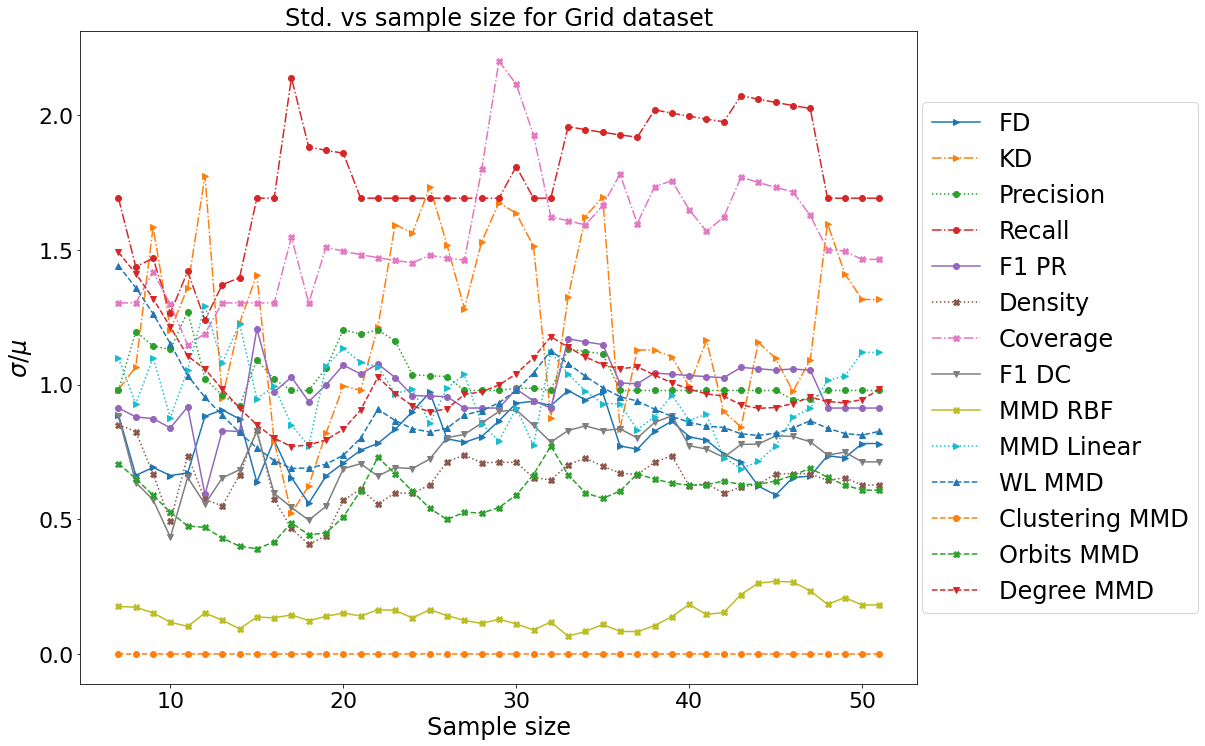

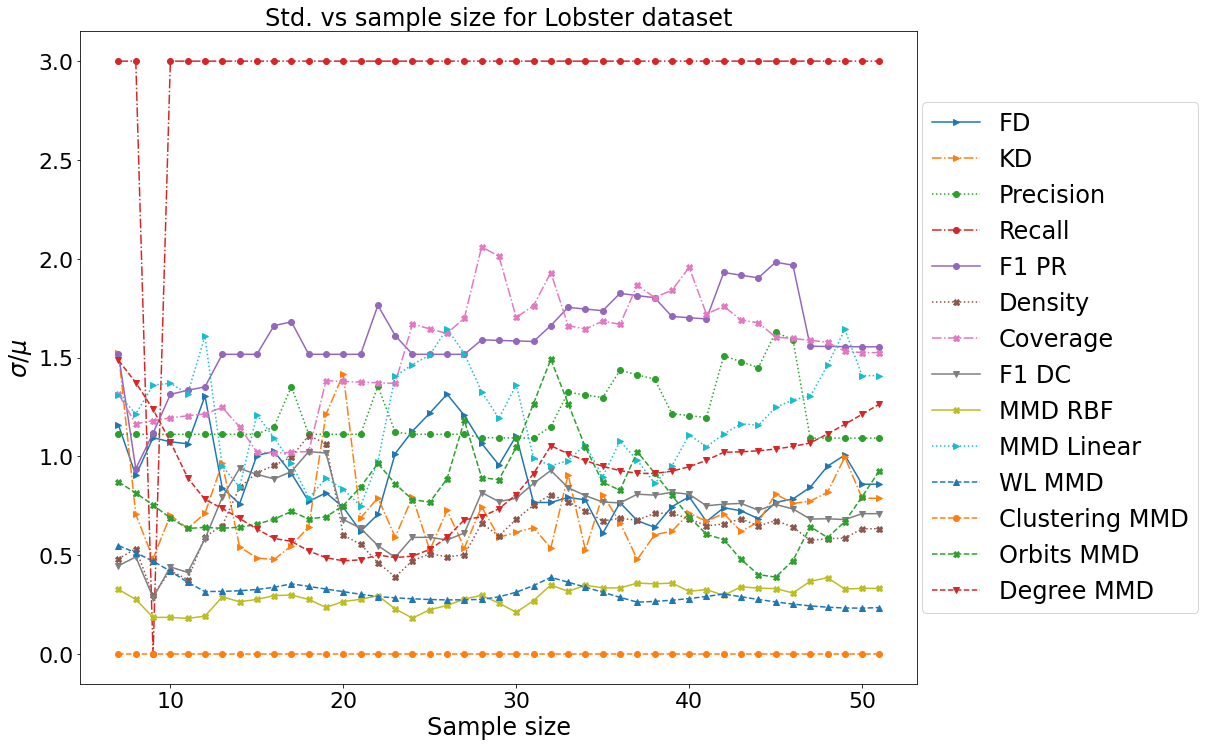

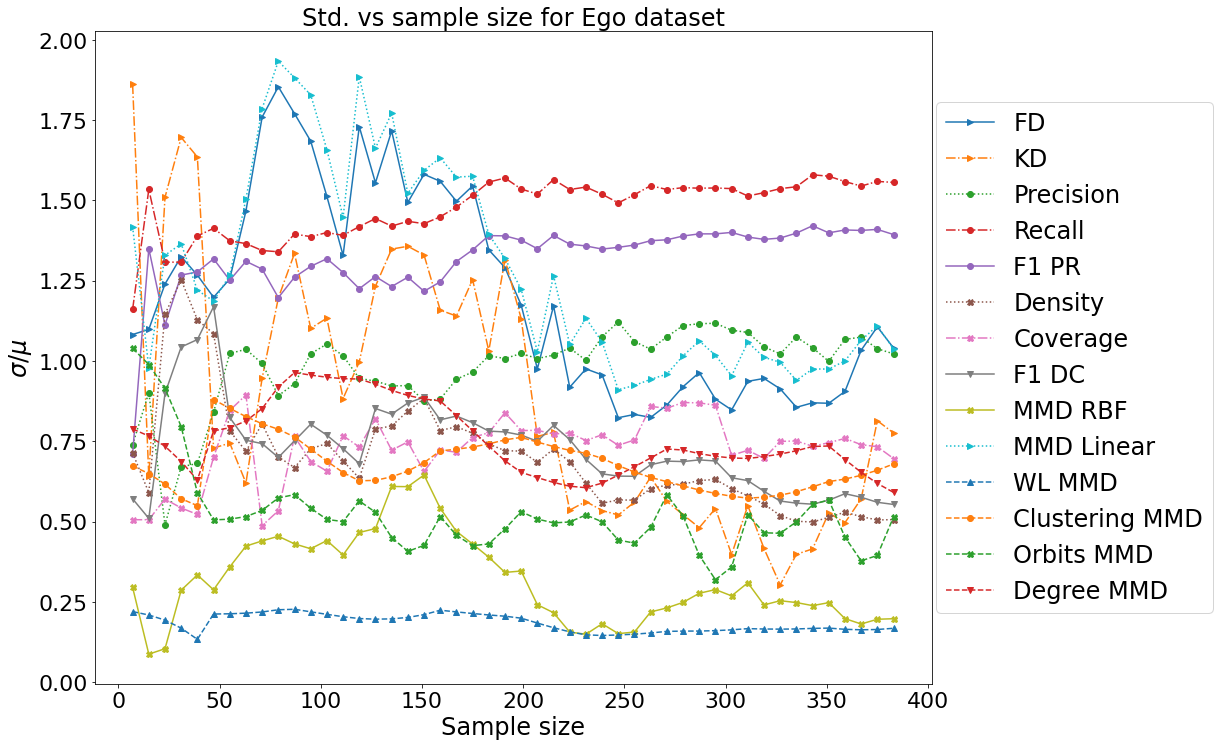

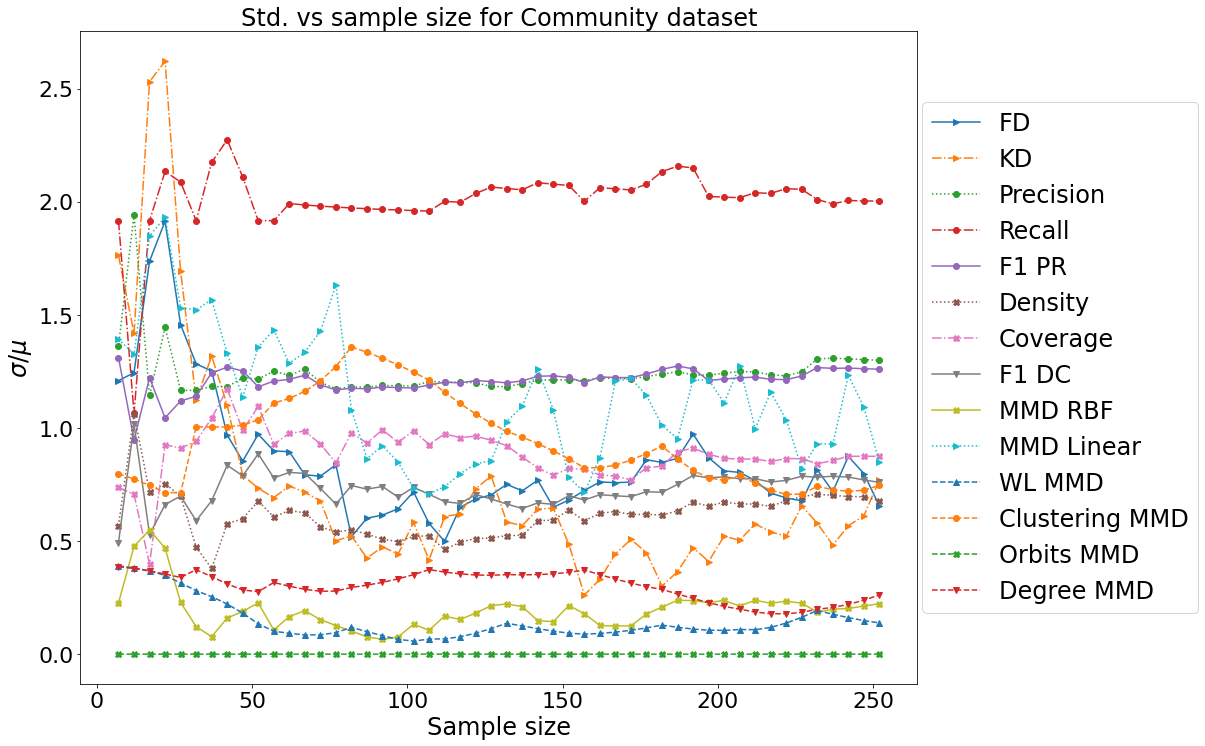

In [140]:
linestyles = {'mmd_rbf_quadratic_adaptive': {'linestyle': '-', 'marker': 'X'},
              'f1_pr': {'linestyle': '-', 'marker': 'o'},
              'f1_dc': {'linestyle': '-', 'marker': 'v'},
              'coverage': {'linestyle': '-.', 'marker': 'X'},
              'recall': {'linestyle': '-.', 'marker': 'o'},
              'density': {'linestyle': ':', 'marker': 'X'},
              'precision': {'linestyle': ':', 'marker': 'o'},
              'orbits_mmd': {'linestyle': '--', 'marker': 'X'},
              'clustering_mmd': {'linestyle': '--', 'marker': 'o'},
              'degree_mmd': {'linestyle': '--', 'marker': 'v'},
              'wl_mmd': {'linestyle': '--', 'marker': '^'},
#               'mmd_rbf_quadratic': {'linestyle': '-', 'marker': '>'}
              'fid': {'linestyle': '-', 'marker': '>'},
              'kid': {'linestyle': '-.', 'marker': '>'},
              'mmd_linear': {'linestyle': ':', 'marker': '>'}
             }

import os
from utils.experiment_logging import get_config, get_results
normalize = True

datasets = ['grid', 'lobster', 'ego', 'community']
# datasets = ['grid', 'proteins', 'lobster', 'ego', 'community']
for dataset in datasets:
    print(dataset)
    all_results = {}
    for root, subdir, files in os.walk('experiment_results'):
        if 'sample-size-random' not in root or 'results.h5' not in files:
            continue

        config = get_config(run_dir=root)
        if config['feature_extractor'] == 'gin' and (config['init'] == 'default' or config['use_pretrained']):
            continue
        if config['dataset'] != dataset:
            continue

        experiment_results = get_results(run_dir=root)
        metrics = ['_'.join(key.split('_')[1: ]) for key in experiment_results[0].keys() if '_time' not in key and 'real' in key and 'best_fit' not in key and 'corr' not in key]

        if config['feature_extractor'] == 'gin':
            str_rep = 'P: {}, N: {}, G: {} '.format(config['num_layers'], config['hidden_dim'], config['graph_embed_size'])
            gin_sample_size = [result['sample_size'] for result in experiment_results]

        else:
            str_rep = ''
            mmd_sample_size = [result['sample_size'] for result in experiment_results]

        for metric in metrics:
            key = ''.join([str_rep, metric])
            metric_results = np.array([result['real_' + metric] for result in experiment_results]).reshape(1, -1)
            if key not in all_results:
                all_results[key] = metric_results
            else:
                all_results[key] = np.concatenate([all_results[key], metric_results], axis=0)    

    fig, ax = plt.subplots(figsize=(15, 12))
    for key, results in all_results.items():
        if 'P: 3, N: 35, G: 70' in key or key in mmd_metrics:
            if results.shape[1] != len(gin_sample_size):
                results = np.concatenate([np.interp(gin_sample_size, mmd_sample_size, res).reshape(1, -1) for res in results], axis=0)
    #             for ix, res in enumerate(results):
    #                 results[ix] = 
            metric = ' '.join(key.split()[-1: ])
            if metric in ['f1_dc', 'f1_pr', 'coverage', 'density', 'precision', 'recall']:
                results = np.concatenate([(max(res) - res).reshape(1, -1) for res in results], axis=0)
                
            std = np.std(results, axis=0)
            mean = np.mean(results, axis=0)
            if metric in to_plot:
                if normalize:
                    ax.plot(gin_sample_size, std / (mean + 1e-10), label=get_label(metric), **linestyles[metric])
                else:
                    ax.plot(gin_sample_size, std, label=get_label(metric), **linestyles[metric])
                    
    if not normalize:
        ax.set_ylim(-0.02, 0.5)
    leg = ax.legend(loc='right')
    if normalize:
        ax.set_ylabel('$\sigma / \mu$')
    else:
        ax.set_ylabel('$\sigma$')
        
    ax.set_xlabel('Sample size')
    ax.set_title('Std. vs sample size for {} dataset'.format(dataset.title()))
    
    
    bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)

    # Change to location of the legend. 
    # xOffset = 0.2 # Play with this to tweak position of legend
    yOffset = 0 # Play with this to tweak position of legend
    bb.y0 -= yOffset
    bb.y1 -= yOffset
    xOffset = -0.35
    bb.x0 -= xOffset
    bb.x1 -= xOffset
    leg.set_bbox_to_anchor(bb, transform=ax.transAxes)